# Détectez des faux billets

### Table des matières

* [1. Import et exploration du fichier](#Import_et_exploration_du_fichier)
    * [a. Affichages et valeurs manquantes](#Affichages_et_valeurs_manquantes)
    * [b. Corrélations entre les variables](#Correlations_entre_les_variables)
    * [c. Distribution des variables](#Distribution_des_variables)
* [2. Implémentation des valeurs manquantes](#Implementation_valeurs_manquantes)    
* [2.1 Regression linéaire simple](#Regression_lineaire_simple)
    * [a. Préparation des données](#preparation_des_donnees)
    * [b. Train test split](#train_test_split_rls)
    * [c. Instanciation - Entraînement - Prédictions](#RLS_instanciation_entrainement_predictions)
    * [d. Evaluation du modèle](#evaluation_du_modele)        
* [2.2. Regression linéaire multiple](#Regression_lineaire_multiple)
    * [a. Préparation des données](#preparation_des_donnees_rm)
    * [b. Train test split](#train_test_split_rm)
    * [c. Instanciation - Entraînement - Prédictions](#RLM_instanciation_entrainement_predictions)
    * [c. Evaluation du modèle](#evaluation_du_modele_rm) 
    * [c.1. Scores](#evaluation_du_modele_rm_scores)
    * [c.2. Analyse des résidus](#evaluation_du_modele_rm_analyse_des_residus) 
    * [d. Implémentation des valeurs manquantes de margin_low](#Implementation_valeurs_manquantes_margin_low)
* [3. Modélisations](#Modelisations)    
    * [a. Préparation des données](#Preparation_des_donnees)
    * [b. Train test split](#Train_test_split)
* [3.1. Dummy Classifier](#Dummy_classifier)
    * [3.1.a Instanciation - Entraînement - Prédictions](#Dummy_classifier_instanciation_entrainement_predictions)
    * [3.1.b Evaluation](#Dummy_classifier_evaluation)
* [3.2. Regression logistique](#Reg_logistique)
    * [3.2.a Grid Search](#Reg_logistique_gridsearch)
    * [3.2.b Instanciation - Entraînement - Prédictions](#Reg_logistique_instanciation_entrainement_predictions)
    * [3.2.c Evaluation](#Reg_logistique_evaluation)
* [3.3. SVM linéaire](#SVM)
    * [3.3.a Grid Search](#SVM_gridsearch)
    * [3.3.b Instanciation - Entraînement - Prédictions](#SVM_instanciation_entrainement_predictions)
    * [3.3.c Evaluation](#SVM_evaluation)
* [3.4 Méthode k-NN](#Methode_kNN)
    * [3.4.a Grid Search](#kNN_gridsearch)
    * [3.4.b Instanciation - Entraînement - Prédictions](#kNN_instanciation_entrainement_predictions)
    * [3.4.c Evaluation](#kNN_evaluation)
* [3.5 Random Forest](#Random_forest)   
    * [3.5.a Grid Search](#Random_forest_gridsearch)
    * [3.5.b Instanciation - Entraînement - Prédictions](#Random_forest_instanciation_entrainement_predictions)
    * [3.5.c Evaluation](#Random_forest_evaluation)
* [3.6. Méthode des K-Means](#Methode_kmeans)
    * [3.6.a. Préparation et standardisation des données](#preparation_et_standardisation_des_donnees)
    * [3.6.b. Méthode du coude et silhouette score](#Methode_du_coude_et_silhouette_score)
    * [3.6.c. Instanciation - Entraînement - Prédictions](#kmeans_instanciation_entrainement_predictions)
    * [3.6.d. Centroïdes](#Centroides)
    * [3.6.e. Evaluation](#KMeans_evaluation)
    * [3.6.f. Predictions sur de nouveaux billets](#KMeans_predictions_nouveaux_billets)    
* [4. Comparaison des performances des modèles](#Comparaison_performances) 
* [5. Application finale](#Application_finale) 

## 1. Import et exploration du fichier<a class="anchor" id="Import_et_exploration_du_fichier"></a>

In [480]:
# J'importe les différentes librairies qui me serviront dans le cadre de ce projet

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn import cluster, metrics

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import model_selection

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image

import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from scipy import stats
import statsmodels.regression

import statistics

### 1.a. Affichage et valeurs manquantes<a class="anchor" id="Affichages_et_valeurs_manquantes"></a>

In [481]:
# J'importe mon fichier billets (après avoir désactivé les messages d'avertissement)

import warnings
warnings.filterwarnings('ignore')

billets = pd.read_excel('billets.xlsx')
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Ces données contiennent les informations de 1500 billets de banque, dont 1000 sont authentiques et 500 sont faux. 
On y trouve des informations qui vont décrire chaque billet dont :
* la diagonale du billet : 'diagonal'
* la hauteur gauche du billet : 'height_left'
* la hauteur droite du billet : 'height_right'
* la marge inférieure entre le bord du billet et l'image :'margin_low'
* la marge supérieure entre le bord du billet et l'image :'margin_up'
* la longueur du billet :'length'

La variable is-genuine indique si le billet est authentique ou non par les indicatifs True ou False. 

In [482]:
# Je vérifie la taille de mon dataframe

billets.shape

(1500, 7)

In [483]:
# Quel est le type de mes variables ?

billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [484]:
# Combien y a t-il de valeurs uniques par colonne ?

billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

>Nous avons 6 variables quantitatives et 1 variable qualitative comprenant 2 valeurs uniquement : True or False

In [485]:
# J'affiche les caractéristiques de mon dataframe

billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [486]:
# Y a t-il des doublons ?

billets.duplicated().sum()

0

In [487]:
# Combien y a t-il de valeurs manquantes par colonne ?

billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [488]:
# Et en pourcentage

round(billets.isna().mean(),3)

is_genuine      0.000
diagonal        0.000
height_left     0.000
height_right    0.000
margin_low      0.025
margin_up       0.000
length          0.000
dtype: float64

>Il y a 37 valeurs manquantes sur la variable margin_low, soit 2,5% des valeurs de la variable. 

In [489]:
# J'affiche les lignes contenant les valeurs manquantes sur margin_low

billets.loc[billets['margin_low'].isna(),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [490]:
# Vérifions que nous avons bien 1000 vrais billets et 500 faux billets

billets.iloc[:,0].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [491]:
# Et en pourcentage

billets.iloc[:,0].value_counts(normalize=True).round(2)

True     0.67
False    0.33
Name: is_genuine, dtype: float64

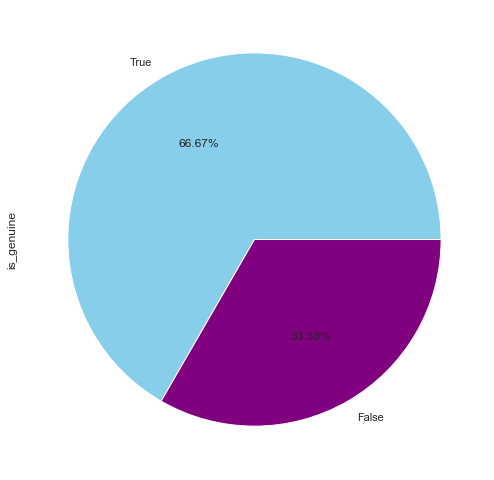

In [492]:
# Voyons cela graphiquement

plt.figure(figsize = (8,8))
billets.iloc[:,0].value_counts().plot(kind ='pie', autopct='%.2f%%', colors = ['skyblue','purple'])
plt.show()

### 1.b. Corrélations entre les variables<a class="anchor" id="Correlations_entre_les_variables"></a>

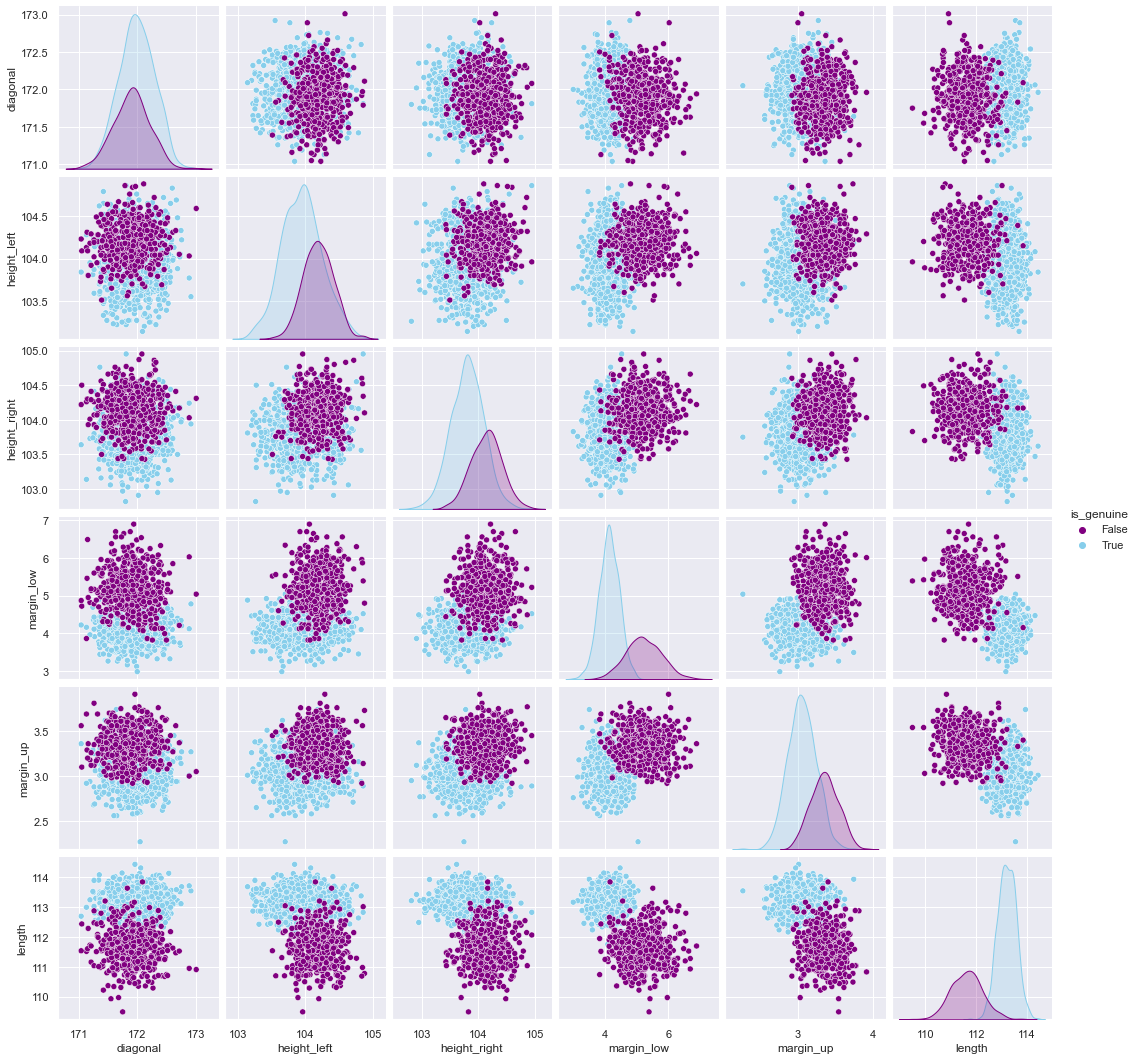

In [493]:
# Regardons maintenant la correlation entre nos différentes variables et en particulier entre margin_low et les autres variables
# colorée par l'authenticité des billets

sns.set(style="darkgrid")
sns.pairplot(billets, hue='is_genuine', palette = {False : 'purple', True : 'skyblue'})
plt.show()

>Nous pouvons dire que margin_low est corrélée positivement avec height_left, height_right, margin_up et négativement avec length. 
Elle semble peu correlée avec la variable 'diagonal'.

>On peut voir aussi que les vrais billets et les faux billets présentent des diférences de dimensions moyennes. 

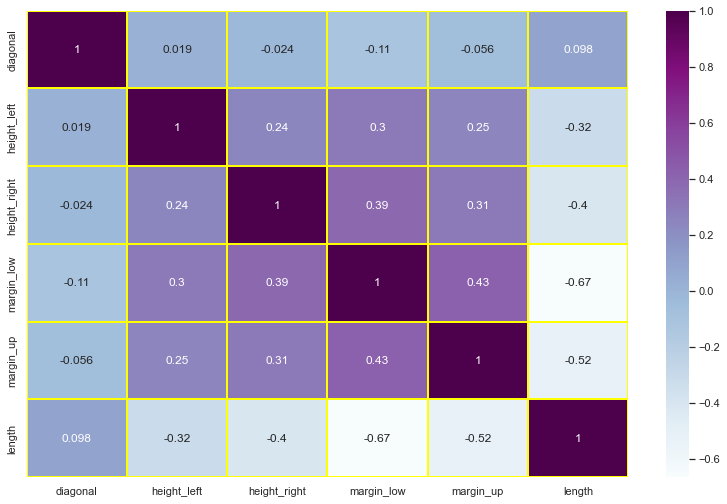

In [494]:
# Pour plus de précision, regardons à l'aide d'une heatmap les corrélations et affichons les coefficients 
# de corrélation entre les variables. 

plt.figure(figsize = (12,8))
sns.heatmap(billets[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']].corr(),annot=True, 
            linewidths=2, linecolor='yellow', cmap="BuPu")
plt.show()

>Margin_low est bien corrélée négativement avec lenght et positivement avec margin_up, height_right et height_left.
La variable la plus corrélée est lenght.

>Pour rappel, plus la corrélation est marquée plus le résultat du coefficient de corrélation tend vers 1 ou -1. Plus il tend vers 0, moins les variables sont corrélées. 

### 1.c. Distribution des variables<a class="anchor" id="Distribution_des_variables"></a>

Regardons les distributions des variables avec des histogrammes, selon l'authenticité des billets.

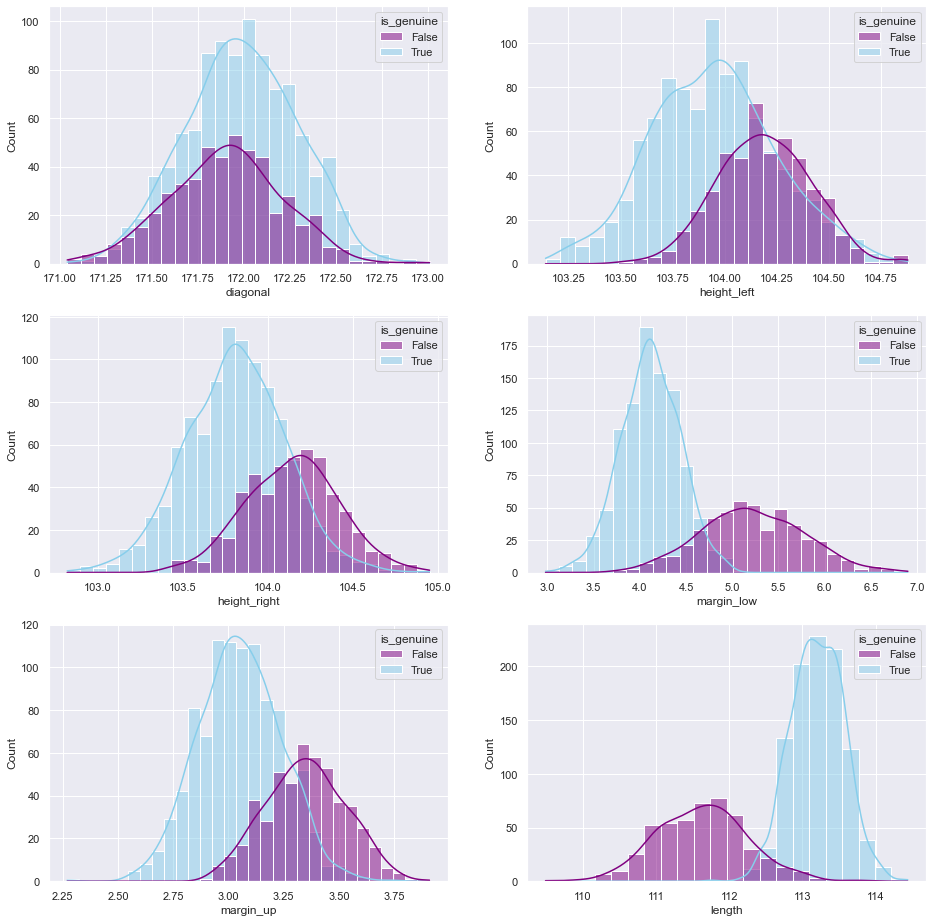

In [495]:
fig, axs = plt.subplots(3, 2, figsize=(14,15))
sns.histplot(data=billets, x="diagonal", kde=True, ax=axs[0, 0], hue='is_genuine', palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=billets, x="height_left", kde=True, ax=axs[0, 1], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=billets, x="height_right", kde=True, ax=axs[1, 0], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=billets, x="margin_low", kde=True, ax=axs[1, 1], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=billets, x="margin_up", kde=True, ax=axs[2, 0], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=billets, x="length", kde=True, ax=axs[2, 1], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
plt.show()

Regardons maintenant les distributions de chacune des variables en fonction de la nature vraie ou fausse du billet avec des boxplots.

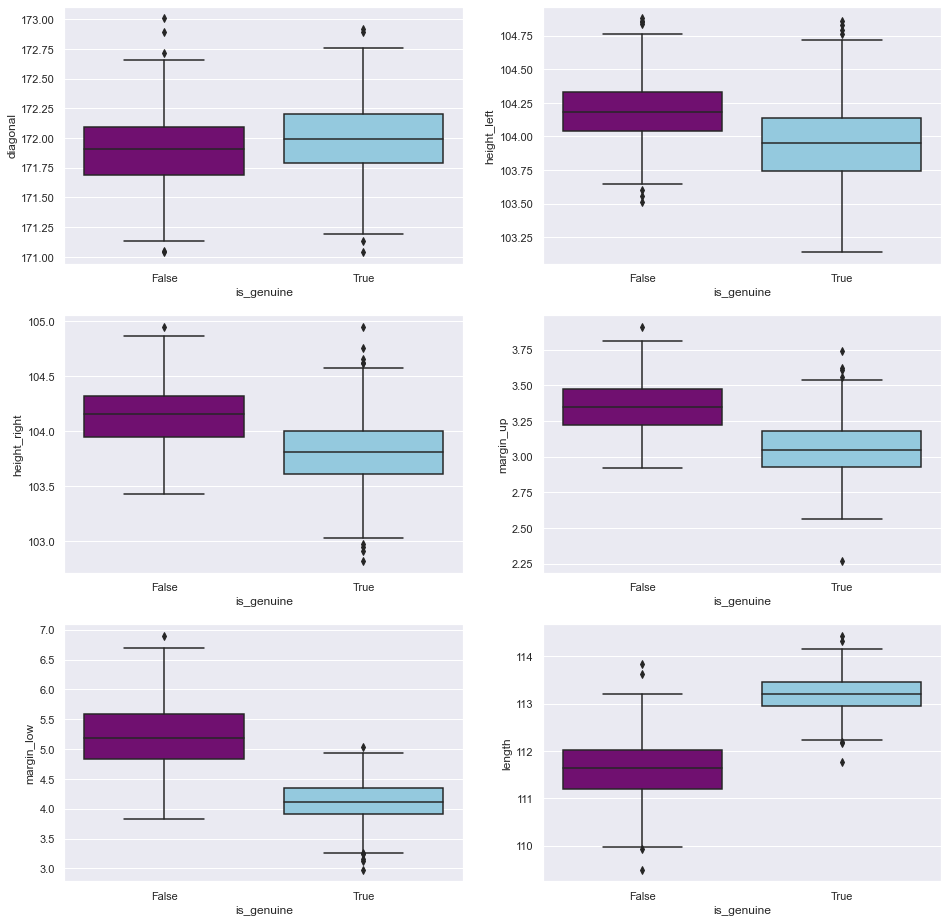

In [496]:
fig, axs = plt.subplots(3, 2, figsize=(14,15))
sns.set_theme(style="ticks", palette="bright")
sns.boxplot(data = billets,x='is_genuine',y='diagonal', ax=axs[0, 0],palette = {False : 'purple', True : 'skyblue'})
sns.boxplot(data = billets,x='is_genuine',y='height_left', ax=axs[0, 1], palette = {False : 'purple', True : 'skyblue'})
sns.boxplot(data = billets,x='is_genuine',y='height_right', ax=axs[1, 0], palette = {False : 'purple', True : 'skyblue'})
sns.boxplot(data = billets,x='is_genuine',y='margin_up', ax=axs[1, 1], palette = {False : 'purple', True : 'skyblue'})
sns.boxplot(data = billets,x='is_genuine',y='margin_low', ax=axs[2, 0], palette = {False : 'purple', True : 'skyblue'})
sns.boxplot(data = billets,x='is_genuine',y='length', ax=axs[2, 1], palette = {False : 'purple', True : 'skyblue'})
plt.show()

>On constate que les faux billets ont le plus souvent des marges plus importantes que les vrais billets, que ce soit sur le haut ou le bas du billet.
Les faux billets ont une hauteur plus importante, à droite et à gauche. 
Ils ont en revanche une longueur plus petite que les vrais billets et une diagonale moindre également. 

## 2. Implémentation des valeurs manquantes <a class="anchor" id="Implementation_valeurs_manquantes"></a>

Il s'agit maintenant de compléter les 37 valeurs manquantes sur la variable margin_low. Nous allons pour cela utiliser la régression linéaire

### 2.1. Régression linéaire simple<a class="anchor" id="Regression_lineaire_simple"></a>

La régression linéaire est une technique d'analyse de données qui prédit la valeur de données inconnues en utilisant une autre valeur de données apparentée et connue. Elle modélise mathématiquement la variable inconnue ou dépendante et la variable connue ou indépendante sous forme d'équation linéaire de type y = a.x + b, où y est la variable à prédire et x est la/les variable(s) connue(s).

### 2.1.a. Préparation des données<a class="anchor" id="preparation_des_donnees"></a>

In [497]:
# Je crée un nouveau dataframe sans les lignes contenant les valeurs manquantes.

billets_bis = billets.dropna(subset=['margin_low'])

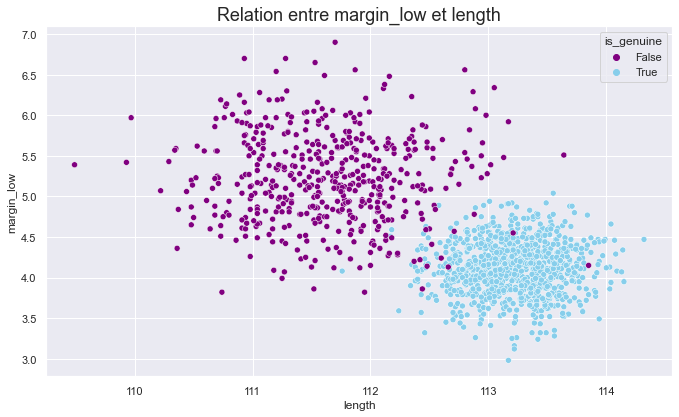

In [498]:
# Avec un scatterplot, j'affiche graphiquement la relation entre 'margin_low' et 'lenght' 

plt.figure(figsize = (10,6))
sns.set(style="darkgrid")
plt.title('Relation entre margin_low et length', fontsize=18)
sns.scatterplot(data = billets_bis, x = 'length', y = 'margin_low', hue = 'is_genuine', palette = {True:'skyblue', False:'purple'})
plt.xlabel('length')
plt.ylabel('margin_low')
plt.show()

In [499]:
# Voyons tout d'abord ce que donne notre regression linéaire simple avec statmodel

reg_simp = smf.ols('margin_low ~ length', data=billets_bis).fit()
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Fri, 07 Apr 2023   Prob (F-statistic):          8.98e-189
Time:                        11:05:25   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

>Nous obtenons des statistiques sur les coefficients obtenus : leur valeur, leur écart-type, la statistique de test de Student, et la p-valeur, ainsi que des statistiques sur le modèle général (R², AIC, etc...).

>Ici, on voit que la variable length est significative.

>Intercept correspond à la valeur de y lorsque X est égal à zéro. C'est le b dans l'équation de regression y = a.x + b

>Quant au R², il est de l'ordre de 0.445. Ce n'est pas très élevé, mais ceci est logique au vu de la dispersion du nuage de points originel. 

Effectuons maintenant notre regression linéaire avec scikit learn.

Je choisis de définir la valeur de margin_low à partir de la valeur de length car il s'agit de la variable la plus correlée. 

In [500]:
# On definit tout d'abord y et X
# y correspond aux valeurs que nous souhaitons prédire

y = billets_bis['margin_low']
y.head()

0    4.52
1    3.77
2    4.40
3    3.62
4    4.04
Name: margin_low, dtype: float64

In [501]:
# X correspond à la variable prédictive à partir de laquelle nous allons trouver y

X = billets_bis['length']
X = pd.DataFrame(billets_bis['length'])
X.head()

,length
0,112.83
1,113.09
2,113.16
3,113.51
4,112.54


### 2.1.b.Train test split<a class="anchor" id="train_test_split_rls"></a>

In [502]:
# Nous allons maintenant séparer nos données en un groupe d'entrainement et un groupe de test. 
# test_size = le pourcentage de données qui vont dans le test, ici 20%
# Avec un random_test égal à 42, la fonction s'effectuera toujours de la même façon et donnera le même résultat. 

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=100)

In [503]:
print('Nous avons X_train de forme', X_train.shape, 'et y_train de forme', y_train.shape,
      'Nous avons X_test de forme', X_test.shape, 'et y_test de forme', y_test.shape)

Nous avons X_train de forme (1170, 1) et y_train de forme (1170,) Nous avons X_test de forme (293, 1) et y_test de forme (293,)


### 2.1.c.Instanciation - Entraînement - Prédictions<a class="anchor" id="RLS_insatnciation_entrainement_predictions"></a>

In [504]:
# Nous pouvons instancier un modèle depuis le package `linear_regression`de scikit-learn.

lr = LinearRegression()

In [505]:
# Maintenant, nous pouvons 'entraîner' notre modèle avec la méthode `fit` sur les données d'entrainement

lr.fit(X_train, y_train)

LinearRegression()

In [506]:
# Nous pouvons utiliser notre modèle pour faire des prédictions.

y_pred = lr.predict(X_test)
y_pred[:20]

array([5.24282913, 4.08188989, 4.07677562, 4.49103147, 4.12791831,
       3.89777617, 5.03314407, 4.01029011, 3.92846179, 4.32226057,
       4.17906101, 5.52922824, 5.37580014, 4.03074719, 4.10234697,
       3.93869033, 4.46546012, 4.41431742, 4.17394674, 4.26088933])

### 2.1.d. Evaluation du modèle de regression linéaire<a class="anchor" id="evaluation_du_modele"></a>

Nous allons maintenant regarder la performance de notre modèle sur les données de train et de test

In [507]:
# Appliquons la fonction .score() à notre modèle.

tr_score = lr.score(X_train, y_train).round(4)
te_score = lr.score(X_test, y_test).round(4)

print('Score train :', tr_score,'et Score test :', te_score)

Score train : 0.4527 et Score test : 0.4115


In [508]:
# Calculons le coeeficient R² de notre régression linéaire simple

r2_RLS = r2_score(y_test, y_pred).round(4)
r2_RLS

0.4115

>Le R² ou coefficient de détermination est équivalent au score test.

>Il mesure de la qualité de prédiction d’une régression linéaire et en cela va faciliter la comparaison entre différents modèles de régression linéaire.

>Le R² correspond à l’erreur du modèle divisé par l’erreur d’un modèle basique qui prédit tout le temps la moyenne de la variable à prédire Le score R2 est d’autant plus élevé que le modèle est performant, et vaut au maximum 1, lorsque toutes les prédictions sont exactes. Il n’y a pas de score minimum, mais un modèle simple prédisant tout le temps la valeur moyenne atteint un score R² de 0. Par conséquent un score R2 négatif signifie que les prédictions sont moins bonnes que si l’on prédisait systématiquement la valeur moyenne.


>Graphiquement, plus le coefficient de détermination se rapproche de 0, plus le nuage de points se disperse autour de la droite de régression.
Au contraire, plus le R² tend vers 1, plus le nuage de points se resserre autour de la droite de régression. 
Quand les points sont exactement alignés sur la droite de régression, alors R² = 1.

In [509]:
# Calculons la MAE (l'erreur absolue moyenne), la moyenne arithmétique des valeurs absolues des écarts entre 
# les valeurs prédites et les valeurs réelles

RLS_mae = mean_absolute_error(
    y_test,
    y_pred
).round(4)
print("l'erreur absolue moyenne MAE est de", RLS_mae)

l'erreur absolue moyenne MAE est de 0.3826


In [510]:
# Calculons la RMSE, l'erreur quadratique moyenne. C'est un coefficient de dispersion qui va nous donner une idée 
# de la dispersion des écarts de prédiction.

RLS_rmse = round(math.sqrt(RLS_mae),4)
print("L'erreur quadratique moyenne RMSE est de", RLS_rmse)

L'erreur quadratique moyenne RMSE est de 0.6185


In [511]:
# Calculons La MAPE (Mean Absolute Percentage Error). C'est la moyenne des écarts de prédictions en valeur absolue par rapport 
# aux valeurs réelles. C’est donc un pourcentage et par conséquent un indicateur pratique de comparaison. 

RLS_mape = round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,4)
print("L'erreur absolue moyenne en pourcentage MAPE est de", RLS_mape)

L'erreur absolue moyenne en pourcentage MAPE est de 8.4535


#### Cross validation

In [512]:
# Cross validation

# la validation croisée est une technique d’évaluation d’un algorithme de Machine Learning consistant à entrainer et tester 
# le modèle sur plusieurs morceaux du dataset de départ.

# L'exemple suivant montre comment estimer la précision d'une régression linéaire sur l'ensemble des données en divisant 
# les données, en ajustant un modèle et en calculant le score 5 fois consécutives (avec des divisions différentes à chaque fois)
# On peut choisir le score à calculer. Ici le r2.

scores = cross_val_score(lr, X, y, cv=5, scoring = 'r2').round(4)
scores

array([-0.5704, -0.4864, -0.4271,  0.298 , -0.6365])

In [513]:
# Nous pouvons calculer la moyenne des 5 scores et l'écart type moyen

print("Le score moyen est de", scores.mean().round(2), "avec un écart type moyen de",scores.std().round(2))

Le score moyen est de -0.36 avec un écart type moyen de 0.34


>Nous pouvons noter que le R² calculé avec la cross validation est très différent du R² calculé avec la fonction r2_score. D'ailleurs le R² calculé avec la fonction r2_score est beaucoup plus proche de ce que nous attendons.

In [514]:
# Créons une fonction pour calculer notre R² :

def r_squared(y, y_pred):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_pred)**2).sum()
    return 1 - (ss_res/ss_tot)

Nous pouvons effectuer notre Cross validation, à l'aide d'une boucle. Nous allons pouvoir calculer les scores
pour chacun des folds.

Nous choisssons toujours 5 folds.

In [515]:
KF = KFold(n_splits = 5)

r2_RLS_list = []
MAE_RLS_list = []
RMSE_RLS_list = []
MAPE_RLS_list = []

for i, (train_index, test_index) in enumerate(KF.split(X)) :
    
    print('{}\n'.format(i))
    # print(train_index, test_index)
    X_train, y_train = X.iloc[train_index],y.iloc[train_index]
    print(X_train.shape, y_train.shape)
    X_test, y_test = X.iloc[test_index],y.iloc[test_index]
    print(X_test.shape, y_test.shape)
    
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    print("R2 :",r2_score(y_test,y_pred).round(4))
    r2_RLS_list.append(r2_score(y_test,y_pred))
    
    print("MAPE :", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,4))
    MAPE_RLS_list.append(np.mean(np.abs((y_test - y_pred) / y_test))*100)
    
    print("MAE :",mean_absolute_error(y_test,y_pred).round(4))
    MAE_RLS_list.append(mean_absolute_error(y_test,y_pred))
    MAE_RLS = mean_absolute_error(y_test,y_pred)
    
    print("RMSE :",round(math.sqrt(MAE_RLS),4))
    RMSE_RLS_list.append(math.sqrt(MAE_RLS))
    
    print("r_squared :", r_squared(y_test,y_pred).round(4))
    
    print('\n')

0

(1170, 1) (1170,)
(293, 1) (293,)
R2 : -0.5704
MAPE : 7.7587
MAE : 0.3105
RMSE : 0.5572
r_squared : -0.5704


1

(1170, 1) (1170,)
(293, 1) (293,)
R2 : -0.4864
MAPE : 7.9796
MAE : 0.3173
RMSE : 0.5633
r_squared : -0.4864


2

(1170, 1) (1170,)
(293, 1) (293,)
R2 : -0.4271
MAPE : 8.0424
MAE : 0.3209
RMSE : 0.5665
r_squared : -0.4271


3

(1171, 1) (1171,)
(292, 1) (292,)
R2 : 0.298
MAPE : 9.4888
MAE : 0.4703
RMSE : 0.6857
r_squared : 0.298


4

(1171, 1) (1171,)
(292, 1) (292,)
R2 : -0.6365
MAPE : 10.1965
MAE : 0.5486
RMSE : 0.7407
r_squared : -0.6365




In [516]:
# Je peux afficher les coefficients de détermination pour chacun des splits

r2_RLS_list

[-0.5703678787705859,
 -0.4864056379240502,
 -0.4271273140574512,
 0.29800325843110276,
 -0.6365328503576326]

In [517]:
# et faire la moyenne des coefficients obtenus

r2_RLS_mean = statistics.mean(r2_RLS_list).round(4)
r2_RLS_mean

-0.3645

In [518]:
# De la même façon, j'affiche juste la MAE de chacun des splits

MAE_RLS_list

[0.31051149350696367,
 0.31729549147854014,
 0.32087318204082144,
 0.4702523736016102,
 0.5486196654501821]

In [519]:
# Puis j'en fait une moyenne

MAE_RLS_mean = statistics.mean(MAE_RLS_list).round(4)
MAE_RLS_mean

0.3935

In [520]:
# J'affiche la liste de l'erreur quadratique moyenne

RMSE_RLS_list

[0.5572355816949988,
 0.5632898822795773,
 0.5664566903487163,
 0.6857494977042347,
 0.7406886427171556]

In [521]:
# Puis j'en fait la moyenne

RMSE_RLS_mean = round(statistics.mean(RMSE_RLS_list),4)
RMSE_RLS_mean

0.6227

In [522]:
# J'affiche la liste de l'erreur moyenne absolue en pourcentage

MAPE_RLS_list

[7.758682512368805,
 7.979559303960309,
 8.042371305407896,
 9.48879000126087,
 10.19651890225088]

In [523]:
# Et j'en fait la moyenne

MAPE_RLS_mean = round(statistics.mean(MAPE_RLS_list),4)
MAPE_RLS_mean

8.6932

In [524]:
# Appliquons la boucle à un dummy Regressor
# Le dummy regressor est un regresseur factice qui donne une prédiction basée sur des stratégies simples sans prêter 
# attention aux données d'entrée. Comme le Dummy Classifier, il est utilisé pour configurer une ligne de base et comparer
# ses écarts de prédiction à ceux d'autres régresseurs existants (regression linéaire)

from sklearn.dummy import DummyRegressor

dummy_r = DummyRegressor(strategy = 'mean')

KF = KFold(n_splits = 5)

for i, (train_index, test_index) in enumerate(KF.split(X)) :
    
    print('{}\n'.format(i))
    # print(train_index, test_index)
    X_train, y_train = X.iloc[train_index],y.iloc[train_index]
    print(X_train.shape, y_train.shape)
    X_test, y_test = X.iloc[test_index],y.iloc[test_index]
    print(X_test.shape, y_test.shape)
    
    dummy_r.fit(X_train, y_train)
    y_pred = dummy_r.predict(X_test)
    
    print("R2 :",r2_score(y_test,y_pred).round(4))
    
    print("MAPE :", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,4))
    
    print("MAE :",mean_absolute_error(y_test,y_pred).round(4))
    MAE_RLS = mean_absolute_error(y_test,y_pred)
    
    print("RMSE :",round(math.sqrt(MAE_RLS),4))
    
    print("r_squared :", r_squared(y_test,y_pred).round(4))
    print('\n')

0

(1170, 1) (1170,)
(293, 1) (293,)
R2 : -2.1564
MAPE : 11.99
MAE : 0.4706
RMSE : 0.686
r_squared : -2.1564


1

(1170, 1) (1170,)
(293, 1) (293,)
R2 : -2.1142
MAPE : 12.5521
MAE : 0.4894
RMSE : 0.6996
r_squared : -2.1142


2

(1170, 1) (1170,)
(293, 1) (293,)
R2 : -1.909
MAPE : 12.3894
MAE : 0.4836
RMSE : 0.6954
r_squared : -1.909


3

(1171, 1) (1171,)
(292, 1) (292,)
R2 : -0.4146
MAPE : 13.1388
MAE : 0.6799
RMSE : 0.8246
r_squared : -0.4146


4

(1171, 1) (1171,)
(292, 1) (292,)
R2 : -2.9651
MAPE : 17.2053
MAE : 0.9398
RMSE : 0.9695
r_squared : -2.9651




>Le dummy regressor nous donne bien des résultats moins bons que notre modèle de régression linéaire.

Notre modèle permet de calculer y (margin_low) en fonction de X (length).

C'est bien une équation de type `y = a.x + b`.

Nous pouvons retrouver facilement la valeur de `a`et de `b`.

In [525]:
# a correspond à la pente de la droite de regression linéaire. 
# (si a>0, la droite est croissante, si a=0, la droite est horizontale, si a<0, la droite est décroissante)

a = lr.coef_
print(a)

[-0.45575957]


In [526]:
# b correspond à l’intercept qui est l'ordonnée du point d'intersection de la droite avec l'axe vertical en x = 0

b = lr.intercept_
print(b)

55.770357089803255


In [527]:
# On peut aussi facilement calculer la valeur de y (margin_low), à partir de l'équation : y = a.x + b 
# Par exemple pour la première valeur manquante, x = 112.79 (valeur de length)

exemple = (a * 112.79 + b).round(2)
print(exemple)

[4.37]


>Pour une longueur de billet de 112,79mm, on trouve une marge inférieure d'environ 4,37mm

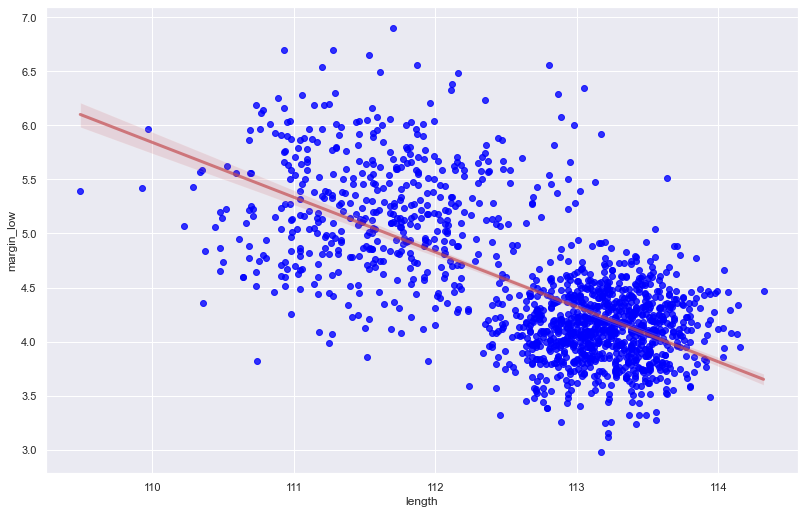

In [528]:
# Traçons maintenant notre droite de régression `y = a.x+b` sur notre nuage de points.

fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.set(style="darkgrid")

ax.set_xlabel("length")
ax.set_ylabel("margin_low")

sns.regplot(data = billets_bis, x = 'length', y = 'margin_low',  color='blue', line_kws={"color":"r","alpha":0.7,"lw":3})

plt.show()

Nous pouvons maintenant calculer les erreurs (les résidus) et les afficher sur un graphique.

In [529]:
residus = y_pred - y_test
residus.head()

1203   -0.838061
1204   -0.908061
1205   -1.258061
1206   -0.508061
1207   -0.538061
Name: margin_low, dtype: float64

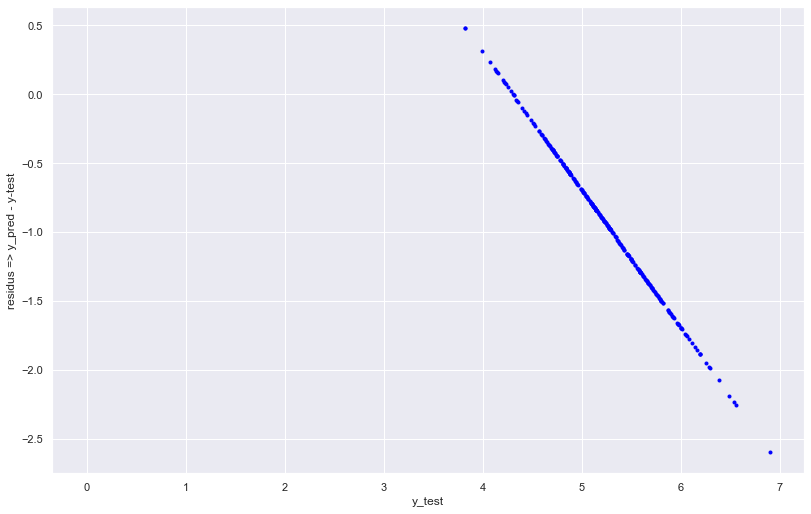

In [530]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.set(style="darkgrid")
ax.set_xlabel("y_test")
ax.set_ylabel("residus => y_pred - y-test")
_ = ax.scatter(y_test.values, residus.values, c="blue", marker=".", alpha=1)
_ = ax.plot([0, 0], [0, 0], c="red")

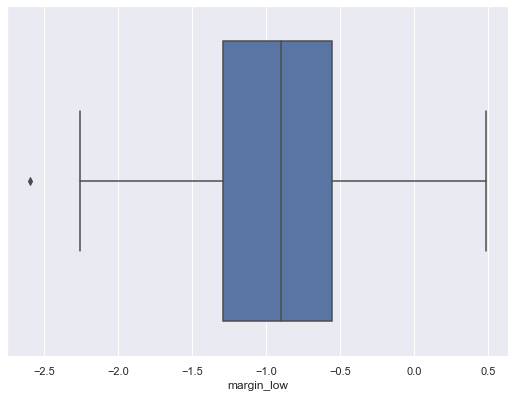

In [531]:
# Continuons l'analyse des résidus, avec un boxplot

fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.boxplot(residus)
plt.show()

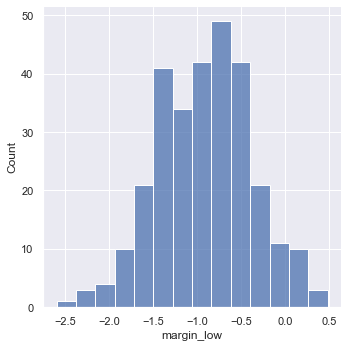

In [532]:
# avec un histogramme

sns.displot(residus)
plt.show()

In [533]:
residus.describe().round(2)

count    292.00
mean      -0.92
std        0.54
min       -2.60
25%       -1.29
50%       -0.90
75%       -0.56
max        0.48
Name: margin_low, dtype: float64

### 2.2 Regression linéaire multiple<a class="anchor" id="Regression_lineaire_multiple"></a>

La regression linéaire multiple est la même chose que la régression linéaire simple si ce n'est qu'au lieu d'utiliser une variable quantitative X indépendante pour prédire les valeurs y de notre variable target, elle va utiliser une combinaison de plusieurs variables quantitatives X, toutes associées à un coefficient qui va correspondre à l'impact de la variable X sur y (à sa contribution dans le modèle). Plus le coefficient s'éloigne de zéro et plus la contribution de la variable est importante).

In [534]:
# Voyons tout d'abord ce que cela donne avec statmodel

regression_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billets_bis).fit()
print(regression_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 07 Apr 2023   Prob (F-statistic):          2.60e-202
Time:                        11:05:27   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

>Le $R^{2}$ vaut environ 0.477, et le $R^{2}$ ajusté est d'environ 0.476.
Cette valeur est très légeremment plus élevée qu'en régression linéaire simple (où nous avions 0.4446), et c'est logique, car lorsque l'on rajoute des variables explicatives potentielles, on accroît naturellement la valeur de $R^{2}$.

### 2.2.a. Préparation des données<a class="anchor" id="preparation_des_donnees_rm"></a>

In [535]:
# Effectuons maintenant une regression linéaire multiple avec scikit learn

# Commençons par séparer nos données. 
# D'un côté, X, l'ensemble de nos variables quantitatives descriptives et de l'autre y, notre variable 'target', margin_low.

X = billets_bis.drop(columns = ['margin_low','is_genuine'])
y = billets_bis.margin_low

In [536]:
X.head()

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54


In [537]:
y.head()

0    4.52
1    3.77
2    4.40
3    3.62
4    4.04
Name: margin_low, dtype: float64

### 2.2.b.Train test split<a class="anchor" id="train_test_split_rm"></a>

In [538]:
# A nouveau, nous séparons nos données en un groupe d'entrainement et un groupe de test. 
# Avec un test_size toujours à 20%

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [539]:
print('Nous avons X_train de forme', X_train.shape, 'et y_train de forme', y_train.shape,
      'Nous avons X_test de forme', X_test.shape, 'et y_test de forme', y_test.shape)

Nous avons X_train de forme (1170, 5) et y_train de forme (1170,) Nous avons X_test de forme (293, 5) et y_test de forme (293,)


### 2.2.c.Instanciation - Entraînement - Prédictions<a class="anchor" id="RLM_instanciation_entrainement_predictions"></a>

In [540]:
# On instancie notre modèle de regression linéaire multiple

reg_multi = LinearRegression()

In [541]:
# On entraine notre modèle sur nos données d'entrainement.

reg_multi.fit(X_train, y_train)

LinearRegression()

In [542]:
# Nous pouvons maintenant prédire les valeurs y_pred, à partir de X_test

y_pred = reg_multi.predict(X_test)
y_pred[:10]

array([4.95663909, 4.29838247, 4.37773033, 4.09528905, 4.02274623,
       4.09556812, 4.85333759, 4.12787564, 4.20096875, 3.86186446])

### 2.2.d. Evaluation du modèle de regression linéaire multiple<a class="anchor" id="evaluation_du_modele_rm"></a>

#### 1. Scores<a class="anchor" id="evaluation_du_modele_rm_scores"></a>

In [543]:
# Nous allons maintenant regarder la performance de notre modèle sur les données test. 
# Appliquons la fonction .score() à notre modèle.

train_score = reg_multi.score(X_train, y_train).round(4)
test_score = reg_multi.score(X_test, y_test).round(4)

print('Score test :', test_score, 'Score train :', train_score)

Score test : 0.5458 Score train : 0.4605


In [544]:
r2_RLM = r2_score(y_test, y_pred).round(4)
print("le R² de notre régression linéaire multiple est de :",r2_RLM)

le R² de notre régression linéaire multiple est de : 0.5458


In [545]:
# Calculons la MAE :

RLM_mae = mean_absolute_error(
    y_test,
    y_pred
).round(4)
print("l'erreur absolue moyenne MAE est de", RLM_mae)

l'erreur absolue moyenne MAE est de 0.3354


In [546]:
# Calculons la RMSE :

RLM_rmse = round(math.sqrt(RLM_mae),4)
print("L'erreur quadratique moyenne RMSE est de", RLM_rmse)

L'erreur quadratique moyenne RMSE est de 0.5791


In [547]:
# Calculons la MAPE :

RLM_mape = round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,4)
print("L'erreur absolue moyenne en pourcentage MAPE est de", RLM_mape)

L'erreur absolue moyenne en pourcentage MAPE est de 7.4677


>On constate que notre modèle de régression linéaire multiple donne de meilleurs résultats que notre modèle de régression linéaire simple. Cela semble normal car nous prenons en compte plus de variables. 

In [548]:
# Effectuons à nouveau une cross validation

# Le score utilisé par défaut est le r2

scores = cross_val_score(reg_multi, X, y, cv=5).round(4)
scores

array([-0.6123, -0.4383, -0.3662,  0.3399, -0.5013])

In [549]:
# Nous pouvons calculer la moyenne de notre r2

r2_mean = scores.mean().round(3)
print("le r2 moyen est de :",r2_mean)

le r2 moyen est de : -0.316


In [550]:
# Calculons nos scores sur une cross validation avec une boucle.

KF = KFold(n_splits = 5)

r2_RLM_list = []
MAE_RLM_list = []
RMSE_RLM_list = []
MAPE_RLM_list = []

for i, (train_index, test_index) in enumerate(KF.split(X)) :
    
    print('{}\n'.format(i))
    # print(train_index, test_index)
    X_train, y_train = X.iloc[train_index],y.iloc[train_index]
    print(X_train.shape, y_train.shape)
    X_test, y_test = X.iloc[test_index],y.iloc[test_index]
    print(X_test.shape, y_test.shape)
    
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    print("R2 :",r2_score(y_test,y_pred).round(4))
    r2_RLM_list.append(r2_score(y_test,y_pred))
    
    print("MAE :",mean_absolute_error(y_test,y_pred).round(4))
    MAE_RLM_list.append(mean_absolute_error(y_test,y_pred))
    MAE_RLM = mean_absolute_error(y_test,y_pred)
    
    print("MAPE :", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,4))
    MAPE_RLM_list.append(np.mean(np.abs((y_test - y_pred) / y_test))* 100)
                        
    print("RMSE :",round(math.sqrt(MAE_RLM),4))
    RMSE_RLM_list.append(math.sqrt(MAE_RLM))
    
    print("r_squared :", round(r_squared(y_test,y_pred),4))
    print('\n')

0

(1170, 5) (1170,)
(293, 5) (293,)
R2 : -0.6123
MAE : 0.3126
MAPE : 7.7793
RMSE : 0.5591
r_squared : -0.6123


1

(1170, 5) (1170,)
(293, 5) (293,)
R2 : -0.4383
MAE : 0.3097
MAPE : 7.7638
RMSE : 0.5565
r_squared : -0.4383


2

(1170, 5) (1170,)
(293, 5) (293,)
R2 : -0.3662
MAE : 0.3112
MAPE : 7.7359
RMSE : 0.5579
r_squared : -0.3662


3

(1171, 5) (1171,)
(292, 5) (292,)
R2 : 0.3399
MAE : 0.4574
MAPE : 9.2494
RMSE : 0.6763
r_squared : 0.3399


4

(1171, 5) (1171,)
(292, 5) (292,)
R2 : -0.5013
MAE : 0.5221
MAPE : 9.7426
RMSE : 0.7226
r_squared : -0.5013




In [551]:
# Je peux maintenant calculer la moyenne des coefficients de détermination r2

r2_RLM_mean = statistics.mean(r2_RLM_list).round(4)
r2_RLM_mean

-0.3156

In [552]:
# Calculons la moyenne de l'erreur moyenne absolue

MAE_RLM_mean = statistics.mean(MAE_RLM_list).round(4)
MAE_RLM_mean

0.3826

In [553]:
# Calculons la moyenne de l'erreur quadratique moyenne

RMSE_RLM_mean = round(statistics.mean(RMSE_RLM_list),4)
RMSE_RLM_mean

0.6145

In [554]:
# Calculons la moyenne de l'erreur moyenne absolue en pourcentage

MAPE_RLM_mean = round(statistics.mean(MAPE_RLM_list),4)
MAPE_RLM_mean

8.4542

#### 2. Analyse des résidus<a class="anchor" id="evaluation_du_modele_rm_analyse_des_residus"></a>

Nous pouvons poursuivre dans l'évaluation avec l'analyse des résidus. L'analyse des résidus a pour objectif de tester la validité d'un modèle de régression. Elle permet de déceler les défaillances d'un modèle.

In [565]:
# Les résidus correspondent donc à la différence entre les valeurs prédites et les valeurs réelles.

residus = y_pred - y_test
residus.head()

1203    0.370194
1204   -0.102789
1205   -0.111221
1206   -0.023651
1207    0.094669
Name: margin_low, dtype: float64

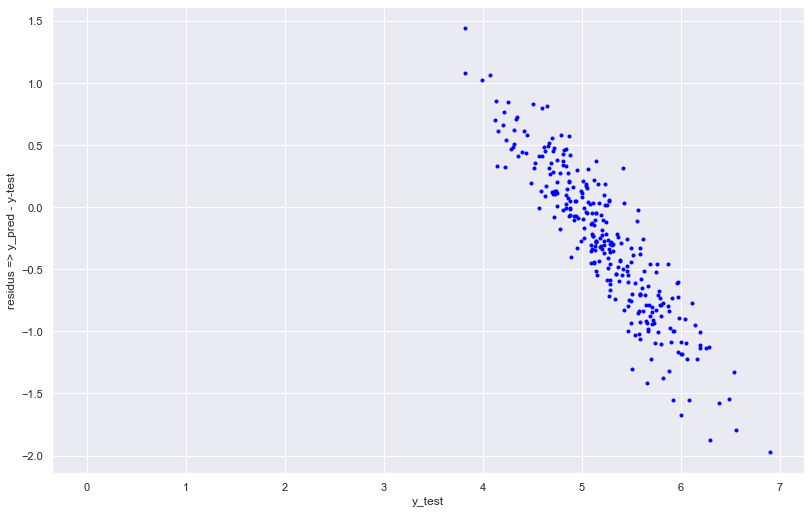

In [561]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.set(style="darkgrid")
ax.set_xlabel("y_test")
ax.set_ylabel("residus => y_pred - y-test")
_ = ax.scatter(y_test.values, residus.values, c="blue", marker=".", alpha=1)
_ = ax.plot([0, 0], [0, 0], c="red")

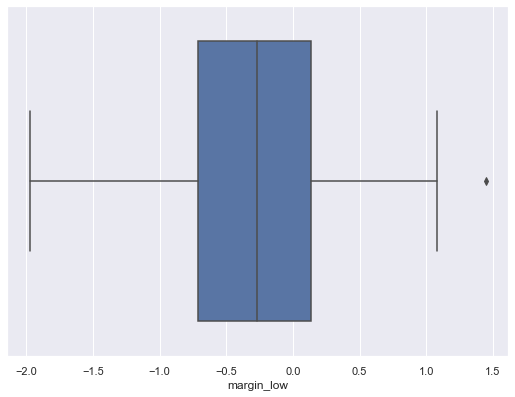

In [562]:
# Continuons l'analyse des résidus, avec un boxplot

fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.boxplot(residus)
plt.show()

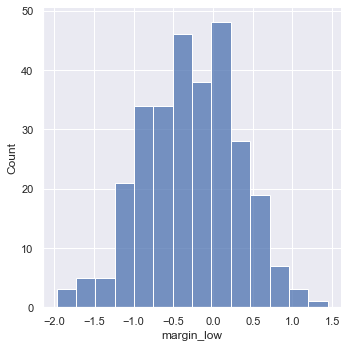

In [563]:
# avec un histogramme

sns.displot(residus)
plt.show()

In [564]:
residus.describe().round(2)

count    292.00
mean      -0.28
std        0.60
min       -1.97
25%       -0.71
50%       -0.27
75%        0.13
max        1.44
Name: margin_low, dtype: float64

In [558]:
# Réalisons un test de Shapiro-Wilk. Le test de Shapiro-Wilk est un test permettant de savoir si une série de données 
# suit une loi normale

shapiro(regression_multi.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

>Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05).
Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

In [557]:
# On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus.
# L’homoscédasticité est essentiellement utile à la compréhension de la structure des données.

_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regression_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216219784e-16


>La p-valeur est inférieure à $5$%, on rejette donc l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

In [559]:
# Regardons maintenant la colinéarité des variables. Une multicolinéarité prononcée s’avère problématique, 
# car elle peut augmenter la variance des coefficients de régression et les rendre instables et difficiles à interpréter.

variables = regression_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686313,
 1.13826057360825,
 1.2301145155560365,
 1.404403778184361,
 1.5769501453665822]

>Ici, tous les coefficients sont proches de 1, il n'y a donc pas de problème de colinéarité

#### Nous allons pouvoir maintenant comparer les performances des deux modèles : régression linéaire simple et régression linéaire multiple. 

In [76]:
# Je compare désormais les performances de la régression linéaire simple et de la régresion linéaire multiple en comparant les 
# coefficients

cols = ['Regression_lineaire_simple','Regression_lineaire_multiple']
index = ['R2', 'MAE','RMSE','MAPE']

performance_modele = pd.DataFrame(index = index, columns = cols)

performance_modele['Regression_lineaire_simple'] = [r2_RLS, MAE_RLS_mean,RMSE_RLS_mean,MAPE_RLS_mean]
performance_modele['Regression_lineaire_multiple'] = [r2_RLM, MAE_RLM_mean,RMSE_RLM_mean,MAPE_RLM_mean]

performance_modele

,Regression_lineaire_simple,Regression_lineaire_multiple
R2,0.4115,0.5458
MAE,0.3935,0.3826
RMSE,0.6227,0.6145
MAPE,8.6932,8.4542


>Nous pouvons donc voir que les erreurs de prédiction sont un peu plus importante avec la régression linéaire simple, qu'avec la régression linéaire multiple et notre R² est meilleur pour la régression linéaire multiple.

>=> Nous allons donc utiliser la régression linéaire multiple pour implémenter les 37 valeurs manquantes sur la variable margin_low.

### 2.2.d. Implémentation des valeurs manquantes de margin_low<a class="anchor" id="Implementation_valeurs_manquantes_margin_low"></a>

Nous allons prévoir les valeurs manquantes de margin_low avec la fonction prédict de la regression linéaire multiple, donc avec l'aide des valeurs de toutes les autres variables quantitatives.

In [77]:
# J'enregistre les lignes contenant les valeurs manquantes dans un nouveau dataframe. 

billets_ter = billets.loc[billets['margin_low'].isna(),:]
billets_ter.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [78]:
# J'enregistre les valeurs de ma colonne is_genuine dans une variable 'is_genuine'

is_genuine = billets_ter.is_genuine.values
is_genuine[:20]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [79]:
# Puis j'enlève les colonnes is_genuine et margin_low de mon dataframe

billets_ter = billets_ter.drop(columns = ['margin_low','is_genuine'])
billets_ter.head()

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [80]:
# Je vérifie la taille de mon dataframe
billets_ter.shape

(37, 5)

>Je retrouve bien un dataframe de 37 lignes

In [81]:
# Je peux donc compléter les valeurs de margin_low avec l'ensemble des autres variables quantitatives

billets_ter['margin_low'] = reg_multi.predict(billets_ter)
billets_ter.head(10)

,diagonal,height_left,height_right,margin_up,length,margin_low
72,171.94,103.89,103.45,3.25,112.79,4.323133
99,171.93,104.07,104.18,3.14,113.08,4.393907
151,172.07,103.80,104.38,3.02,112.93,4.416845
197,171.45,103.66,103.80,3.62,113.27,4.337374
241,171.83,104.14,104.06,3.02,112.36,4.634614
251,171.80,103.26,102.82,2.95,113.22,3.815222
284,171.92,103.83,103.76,3.23,113.29,4.190862
334,171.85,103.70,103.96,3.00,113.36,4.133982
410,172.56,103.72,103.51,3.12,112.95,4.156725
413,172.30,103.66,103.50,3.16,112.95,4.179140


In [82]:
# J'ajoute à mon dataframe, la variable 'is_genuine' préalablement mise de côté

billets_ter['is_genuine'] = is_genuine
billets_ter.head()

,diagonal,height_left,height_right,margin_up,length,margin_low,is_genuine
72,171.94,103.89,103.45,3.25,112.79,4.323133,True
99,171.93,104.07,104.18,3.14,113.08,4.393907,True
151,172.07,103.80,104.38,3.02,112.93,4.416845,True
197,171.45,103.66,103.80,3.62,113.27,4.337374,True
241,171.83,104.14,104.06,3.02,112.36,4.634614,True


In [83]:
# Je concatène ce nouveau dataframe avec le dataframe dans lequel j'avais retiré ces mêmes lignes

billets = pd.concat([billets_bis, billets_ter]) 
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [84]:
# Vérifions que nous n'avons plus de valeurs manquantes

billets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

>Il n'y a plus aucune valeur manquante

In [85]:
# Regardons les nouvelles caractéritiques de notre dataframe et notamment si nous trouvons des abérations. 
# => Ce n'est pas le cas. 

billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483432,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659489,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Regardons les nouvelles distributions de la variable margin_low avec l'ensemble des valeurs présentes.

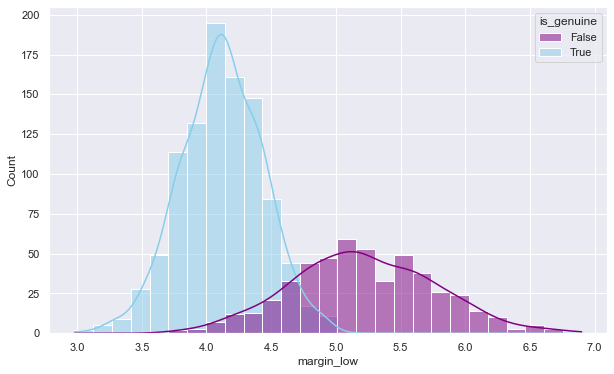

In [86]:
plt.figure(figsize = (10,6))
sns.set(style="darkgrid")
sns.histplot(data=billets, x="margin_low", kde=True, hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
plt.show()

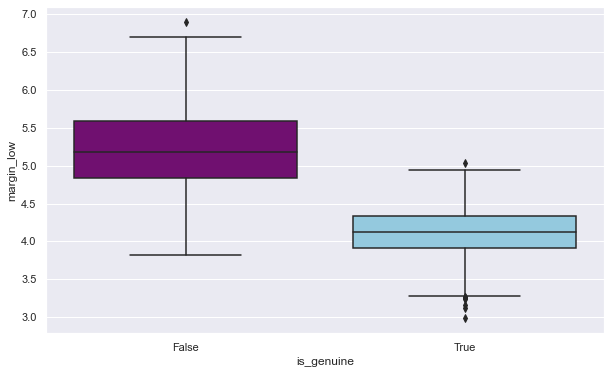

In [87]:
plt.figure(figsize = (10,6))
sns.set(style="darkgrid")
sns.boxplot(data = billets, x='is_genuine',y='margin_low', palette = {False : 'purple', True : 'skyblue'})
plt.show()

In [88]:
# Pour la suite, je remplace les valeur True et False de la variable 'is_genuine' par des 1 et des 0 pour avoir une variable numérique

billets['is_genuine'] = billets['is_genuine'].replace([True,False],[1,0])
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [89]:
# Je vérifie que le type de ma variable est bien au format numérique.

billets.dtypes

is_genuine        int64
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

## 3. Modélisations<a class="anchor" id="Modelisations"></a>

Nous allons tester différentes méthodes de classification dont l'objectif va être de déterminer si de nouveaux billets sont vrais ou faux. 

### 3.a. Préparation des données<a class="anchor" id="Preparation_des_donnees"></a>

In [90]:
# Avant d'effectuer notre regression logistique avec scikit learn, nous allons préparer nos données.

# Commençons par séparer nos données. 
# D'un côté, X, l'ensemble de nos variables quantitatives descriptives et de l'autre y, notre variable target 'is_genuine'

X = billets.drop(columns = 'is_genuine')
y = billets.is_genuine

In [91]:
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [92]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: is_genuine, dtype: int64

In [93]:
# Je standardise mes données X

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.05546738, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08215668, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12655247, -0.91256208,
         0.55190114],
       ...,
       [-0.78153123,  1.43794766,  0.61346228,  1.84368096,  1.97866106,
        -2.71480344],
       [ 2.29949275,  1.00369058,  1.50434862,  1.07915577,  1.76289814,
        -1.38519737],
       [-0.19154792,  0.83666863,  1.135706  ,  0.96723236,  0.38201544,
        -1.36227312]])

###  3.b. Train Test Split<a class="anchor" id="Train_test_split"></a>

In [94]:
# Séparons nos données en un groupe d'entrainement et un groupe de test. 
 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [95]:
print('Nous avons X_train de forme', X_train.shape, 'et y_train de forme', y_train.shape,
      'Nous avons X_test de forme', X_test.shape, 'et y_test de forme', y_test.shape)

Nous avons X_train de forme (1200, 6) et y_train de forme (1200,) Nous avons X_test de forme (300, 6) et y_test de forme (300,)


### 3.1. Dummy Classifier<a class="anchor" id="Dummy_classifier"></a>

L'utilisation du dummy classifier permet de créer une base de référence pour comparer ensuite notre modèle et l'améliorer. 
Un dummy classifier est un modèle de classification qui fait des prédictions sans essayer de trouver de modèle dans les données. Le modèle par défaut examine essentiellement quelle étiquette est la plus fréquente dans le jeu de données d’apprentissage et fait des prédictions basées sur cette étiquette.

La comparaison entre le modèle factice et notre régression logistique pourra se faire en comparant les scores de précision. 

#### 3.1.a Instanciation - Entrainement - Prédictions<a class="anchor" id="Dummy_classifier_instanciation_entrainement_predictions"></a>

In [96]:
# Instancions notre estimator puis entrainons-le sur nos données d'entrainement. 

estimator = DummyClassifier(strategy = 'most_frequent')
estimator.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [97]:
# Ensuite nous pouvons prédire y_pred avec la méthode predict appliquée à X_test. 
# y_pred correspond aux prédictions effectuées par l'estimateur

y_pred = estimator.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

>Il semble n'y avoir que des 1 (True), qui ressortent. 

In [98]:
# Vérifions cela avec la fonction value_counts() appliquée à y_pred transformé en série. 

pd.Series(y_pred).value_counts()

1    300
dtype: int64

>Effectivement, toutes les valeurs sont égales à 1.
Notre Dummy Classifier n'a fait que renvoyer la valeur qui était la plus fréquente, c'est à dire le 1.

In [99]:
# Nous pouvons facilement vérifier que la classe 1 est plus représentée que la classe 0. 

y_test.value_counts(normalize=True).round(2)

1    0.63
0    0.37
Name: is_genuine, dtype: float64

In [100]:
# Regardons les valeurs de y_test

y_test.values

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], d

#### 3.1.b Evaluation<a class="anchor" id="Dummy_classifier_evaluation"></a>

In [101]:
# Nous allons maintenant regarder la performance de notre estimator sur les données de train et de test.
# Appliquons la fonction .score() à notre estimator.

tr_score = estimator.score(X_train, y_train).round(4)
te_score = estimator.score(X_test, y_test).round(4)

print('Score train :', tr_score,'et Score test :', te_score)

Score train : 0.6758 et Score test : 0.63


>Le score test de 0,63 est le nombre de bonnes prédictions par rapport à l'ensemble des prédictions. 

>Nous pouvons donc nous tromper et prédire qu'un billet est authentique alors qu'il ne l'est pas ou inversement qu'un billet est faux, alors qu'il est authentique. 

>Nous pouvons voir que le score test est identique à la fréquence d'apparition de la valeur 1 et c'est le résultat attendu. 
>L'estimateur permet d'avoir un score de base. L'amélioration de notre modélisation se fait dans la fourchette 0,63 -> 1
>Si notre modélisation était de zero, cela voudrait dire que nous sommes à chaque fois capable de prédire l'inverse du résultat attendu. 

In [102]:
# Regardons ce que donne la validation croisée. 
# Nous constatons qu'elle n'est pas concluante sur notre dummy classifier

dc_scores = cross_validate(estimator, X, y, cv=5, scoring = ['accuracy','precision','recall'])
dc_scores

{'fit_time': array([0.00245571, 0.00100756, 0.00101304, 0.        , 0.00100064]),
 'score_time': array([0.00307584, 0.00100899, 0.00212121, 0.00202274, 0.00099921]),
 'test_accuracy': array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
 'test_precision': array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
 'test_recall': array([1., 1., 1., 1., 1.])}

#### Calculons la matrice de confusion.

La matrice de confusion permet d'évaluer la qualité du modèle en confrontant les valeurs prédites avec les vraies valeurs prises par y. 

In [103]:
# Appliquons la fonction confusion_matrix à y_test et y_pred pour calculer la matrice de confusion

mat = confusion_matrix(y_test,y_pred)
mat

array([[  0, 111],
       [  0, 189]], dtype=int64)

In [104]:
# Transformons cela en dataframe

mat = pd.DataFrame(mat)
mat

,0,1
0,0,111
1,0,189


In [105]:
# Nommons nos lignes et nos colonnes

mat.columns = [f"pred_{i}"for i in mat.columns]
mat.index = [f"test_{i}"for i in mat.index]
mat

,pred_0,pred_1
test_0,0,111
test_1,0,189


>Nous pouvons dire dans ce cas que notre modèle a prédit 111 fois 1 alors que la vraie valeur de y était 0 et 189 fois 1 et c'était la bonne valeur. 

In [106]:
# Définissons une fonction pour calculer la matrice de confusion

def confusion(y_test,y_pred) :
    """Affiche la matrice de confusion"""
    
    mat = confusion_matrix(y_test,y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}"for i in mat.columns]
    mat.index = [f"test_{i}"for i in mat.index]
    
    return mat

In [107]:
# Vérifions si notre fonction est opérationnelle

confusion(y_test,y_pred)

,pred_0,pred_1
test_0,0,111
test_1,0,189


In [108]:
# Evaluons notre modèle avec l'accuracy, la précision et le rappel

# L’accuracy est le nombre de bonnes prédictions sur l’ensemble des prédictions. 
# La précision c’est le nombre de vrais positifs sur tous les positifs prédits
# Le rappel c’est le nombre de vrais positifs sur tous les positifs réels. 


dc_accuracy = accuracy_score(y_test, y_pred).round(4)
dc_precision = precision_score(y_test, y_pred).round(4)
dc_recall = recall_score(y_test, y_pred).round(4)

print("Accuracy:", dc_accuracy)
print("Precision:", dc_precision)
print("Recall:", dc_recall)

Accuracy: 0.63
Precision: 0.63
Recall: 1.0


In [109]:
# Calculons la performance de notre modèle avec l'AUC ROC.
# L'AUC ROC va mesurer la performance globale de notre modèle

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc_dc = auc(false_positive_rate, true_positive_rate)
print("L'AUC ROC de notre dummy classifier est de :",roc_auc_dc)

L'AUC ROC de notre dummy classifier est de : 0.5


>Notre AUC ROC (ou auroc) est égal à 50%. Pour un modéle parfait, AUC ROC = 100%

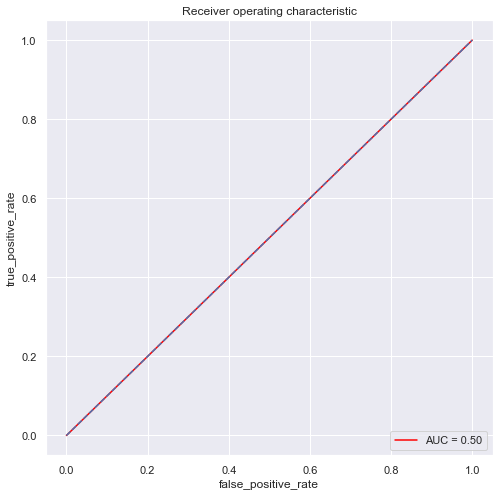

In [110]:
# Regardons graphiquement la répartition des faux positifs et vrais positifs avec la courbe ROC
# les deux indicateurs essentiels qui constituent la courbe ROC sont la sensitivité et la spécificité. 
# La  sensitivité est le taux d’individus positifs correctement prédits "true_positive_rate" (TP / TP + FN)
# La  spécificité est le taux d’individus négatifs correctement prédits "false_positive_rate" (TN / TN + FP)
# La courbe ROC va représenter graphiquement la relation existante entre ces deux indicateurs. 

plt.figure(figsize = (8,8))
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate, true_positive_rate, color ='red', label = 'AUC = %0.2f' % roc_auc_dc)
plt.plot([0,1],[0,1], linestyle ='--')
plt.legend(loc = 'lower right')
plt.axis('tight')
plt.ylabel('true_positive_rate')
plt.xlabel('false_positive_rate')
plt.show()

>L'AUC correspond à l'aire sous la courbe. 

### 3.2. Régression logistique<a class="anchor" id="Reg_logistique"></a>

Effectuons une regréssion logistique de la variable is-genuine en fonction de l'ensemble des autres variables.

La régression logistique est un modèle statistique permettant d’étudier les relations entre un ensemble de variables explicatives Xi et une variable dépendante Y.
Un modèle de régression logistique permet aussi de prédire la probabilité qu’un événement arrive ou non à partir de l’optimisation des coefficients de régression.

La régression logistique est est un algorithme de classification. Elle est utilisée lorsque la variable réponse est binaire. 

In [111]:
# Essayons avec statmodel

reg_log = smf.glm('is_genuine~+diagonal+height_left+height_right+margin_low+margin_up+length',
                    data=billets, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1493
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.327
Date:                Fri, 07 Apr 2023   Deviance:                       84.654
Time:                        09:15:10   Pearson chi2:                 2.68e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7038
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -204.9180    241.683     -0.848   

#### 3.2.a Grid Search<a class="anchor" id="Reg_logistique_gridsearch"></a>

#### Commençons par effectuer un GridSearch

Le grid search est une méthode d'optimisation des hyperparamètres d'un modèle de machine learning.

Le grid search crée des modèles correspondant à chaque combinaison d'hyperparamètres. Ce qui peut vite faire beaucoup et par conséquent allonger le temps d'entrainement.

On retiendra le modèle donnant le meilleur score. 

In [112]:
# Grid search sur une cross validation

estimateur = LogisticRegression(solver = 'liblinear')

# Nous choisissons un score à optimiser, ici l'auc roc.

score = 'roc_auc'

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":['none', 'elasticnet', 'l1','l2']}

estimateur_cv = GridSearchCV(estimateur,  
                           param_grid = parameters,
                           scoring = score,
                           cv = 5,
                           verbose=0)

estimateur_cv.fit(X_train, y_train)

print("Meilleurs paramètres :",estimateur_cv.best_params_)
print("Meilleur score (roc_auc):",round(estimateur_cv.best_score_,4))

Meilleurs paramètres : {'C': 0.1, 'penalty': 'l2'}
Meilleur score (roc_auc): 0.9987


In [113]:
# Affichons les performances correspondantes

print("Résultats de la validation croisée :")
for mean, std, params in zip(
        estimateur_cv.cv_results_['mean_test_score'], # score moyen
        estimateur_cv.cv_results_['std_test_score'],  # écart-type du score
        estimateur_cv.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
roc_auc = nan (+/-nan) for {'C': 0.001, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 0.001, 'penalty': 'elasticnet'}
roc_auc = 0.500 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
roc_auc = 0.999 (+/-0.002) for {'C': 0.001, 'penalty': 'l2'}
roc_auc = nan (+/-nan) for {'C': 0.01, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 0.01, 'penalty': 'elasticnet'}
roc_auc = 0.996 (+/-0.008) for {'C': 0.01, 'penalty': 'l1'}
roc_auc = 0.999 (+/-0.002) for {'C': 0.01, 'penalty': 'l2'}
roc_auc = nan (+/-nan) for {'C': 0.1, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 0.1, 'penalty': 'elasticnet'}
roc_auc = 0.998 (+/-0.005) for {'C': 0.1, 'penalty': 'l1'}
roc_auc = 0.999 (+/-0.003) for {'C': 0.1, 'penalty': 'l2'}
roc_auc = nan (+/-nan) for {'C': 1, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 1, 'penalty': 'elasticnet'}
roc_auc = 0.998 (+/-0.004) for {'C': 1, 'penalty': 'l1'}
roc_auc = 0.999 (+/-0.004) for {'C': 1, 'penalty': 'l2'}
roc_auc

#### 3.2.b Instanciation - Entraînement - Prédictions<a class="anchor" id="Reg_logistique_instanciation_entrainement_predictions"></a>

In [114]:
# Maintenant que nous detenons les meilleurs paramètres de notre estimateur, nous pouvons l'instancier avec ces paramètres
# puis entrainons-le sur nos données d'entrainement. 

estimateur = LogisticRegression(solver = 'liblinear', C = 10, penalty='l2')
estimateur.fit(X_train,y_train)

LogisticRegression(C=10, solver='liblinear')

In [115]:
# Ensuite nous pouvons prédire y_pred avec la méthode predict appliquée à X_test. 

y_pred = estimateur.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], d

In [116]:
# Nous pouvons prédire la probabilité d'appartenance à telle ou telle classe
# Ici par exemple, la probabilité pour que le premier billet soit faux est de 100% et qu’il soit vrai est de 0%. 
# Pour le deuxième billet, elle est de 98% qu’il soit faux et de 2% qu’il soit vrai

y_prob = estimateur.predict_proba(X_test).round(2)
y_prob

array([[1.  , 0.  ],
       [0.98, 0.02],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.05, 0.95],
       [1.  , 0.  ],
       [0.1 , 0.9 ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.64, 0.36],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  ,

#### 3.2.b Evaluation<a class="anchor" id="Reg_logistique_evaluation"></a>

In [117]:
# Calculons la matrice de confusion

confusion(y_test,y_pred)

,pred_0,pred_1
test_0,110,1
test_1,2,187


In [118]:
# Calculons nos scores de performance : Accuracy, Precision et Rappel

KF = KFold(n_splits = 5)

accuracy_RL_list = []
precision_RL_list = []
recall_RL_list = []

for i, (train_index, test_index) in enumerate(KF.split(X)) :
    print('{}\n'.format(i))
    # print(train_index, test_index)
    X_train, y_train = X.iloc[train_index],y.iloc[train_index]
    print(X_train.shape, y_train.shape)
    X_test, y_test = X.iloc[test_index],y.iloc[test_index]
    print(X_test.shape, y_test.shape)
    
    estimateur.fit(X_train, y_train)
    y_pred = estimateur.predict(X_test)
    
    print("Accuracy :",accuracy_score(y_test, y_pred).round(4))
    accuracy_RL_list.append(accuracy_score(y_test, y_pred).round(4))
    
    print("Precision :",precision_score(y_test, y_pred).round(4))
    precision_RL_list.append(precision_score(y_test, y_pred).round(4))
    
    print("Recall :",recall_score(y_test, y_pred).round(4))
    recall_RL_list.append(recall_score(y_test, y_pred).round(4)) 

0

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 1.0
Precision : 1.0
Recall : 1.0
1

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9967
Precision : 1.0
Recall : 0.9967
2

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9867
Precision : 1.0
Recall : 0.9867
3

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9733
Precision : 0.8987
Recall : 1.0
4

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.99
Precision : 0.9333
Recall : 0.9655


In [119]:
rl_accuracy = statistics.mean(accuracy_RL_list).round(4)
rl_accuracy

0.9893

In [120]:
rl_precision = statistics.mean(precision_RL_list).round(4)
rl_precision

0.9664

In [121]:
rl_recall = statistics.mean(recall_RL_list).round(4)
rl_recall

0.9898

In [122]:
# Calculons maintenant nos score de précision des prédictions de notre modèle avec la fonction cross_validate

rl_scores = cross_validate(estimateur, X, y, cv=5, scoring = ['accuracy','precision','recall'])
rl_scores

{'fit_time': array([0.0044198 , 0.00300169, 0.00199986, 0.00199962, 0.00300336]),
 'score_time': array([0.00327945, 0.00200057, 0.00200009, 0.00250578, 0.00199962]),
 'test_accuracy': array([0.98666667, 0.98666667, 0.99666667, 0.98333333, 0.98666667]),
 'test_precision': array([0.98514851, 0.98039216, 1.        , 0.98994975, 0.99      ]),
 'test_recall': array([0.995, 1.   , 0.995, 0.985, 0.99 ])}

In [123]:
rl_scores = pd.DataFrame(rl_scores)
rl_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall
0,0.004420,0.003279,0.986667,0.985149,0.995
1,0.003002,0.002001,0.986667,0.980392,1.000
2,0.002000,0.002000,0.996667,1.000000,0.995
3,0.002000,0.002506,0.983333,0.989950,0.985
4,0.003003,0.002000,0.986667,0.990000,0.990


In [124]:
# Faisons la moyenne des scores obtenus pour les 5 folds

accuracy = round(rl_scores['test_accuracy'].mean(),4)
print("L'accuracy de notre modèle de régression logistique est de :",accuracy)

L'accuracy de notre modèle de régression logistique est de : 0.988


In [125]:
precision = round(rl_scores['test_precision'].mean(),4)
print("Le score de précision de notre modèle de régression logistique est de :",precision)

Le score de précision de notre modèle de régression logistique est de : 0.9891


In [126]:
recall = round(rl_scores['test_recall'].mean(),4)
print("Le rappel de notre modèle de régression logistique est de :",recall)

Le rappel de notre modèle de régression logistique est de : 0.993


>Les scores de performance sont de l'ordre de 99% et nous n'avons que 3 erreurs de prédiction. 

In [127]:
# Calculons la performance de notre modèle avec l'auc roc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc_rl = auc(false_positive_rate, true_positive_rate).round(4)
print("L'AUC ROC de notre modèle de régression logistique est de :",roc_auc_rl)

L'AUC ROC de notre modèle de régression logistique est de : 0.9791


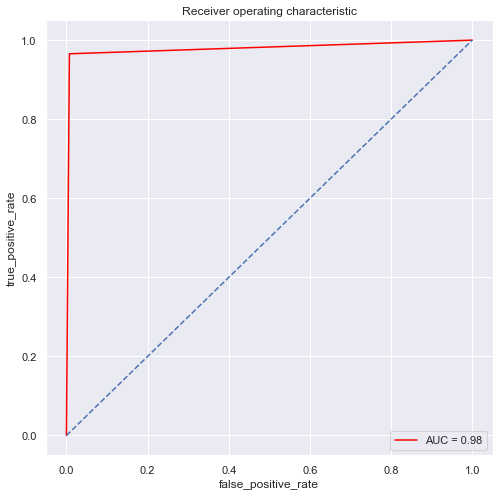

In [128]:
# Et regardons ce que cela donne graphiquement. 
# L'AUC est l'aire qui se situe sous la courbe ROC en rouge. 

plt.figure(figsize = (8,8))
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate, true_positive_rate, color ='red', label = 'AUC = %0.2f' % roc_auc_rl)
plt.plot([0,1],[0,1], linestyle ='--')
plt.legend(loc = 'lower right')
plt.axis('tight')
plt.ylabel('true_positive_rate')
plt.xlabel('false_positive_rate')
plt.show()

>Notre estimator se révèle être excellent ! 

In [129]:
# Nous pouvons aussi calculer les coefficients de regression de notre modèle de regression logistique. 

pd.DataFrame(np.concatenate([estimateur.intercept_.reshape(-1,1),
                             estimateur.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(X.columns)).T

,coef
constante,-0.018755
diagonal,-0.276253
height_left,-1.307654
height_right,-2.777582
margin_low,-4.854026
margin_up,-6.071849
length,4.574098


Comment interpréter ces coefficients ?
Par exemple un coefficient positif, de 4,57 pour la longueur du billet va signifier que plus la longueur est grande, plus le billet a des chances d'être vrai. 
Au contraire, un coefficient négatif comme le margin_low, signifiera que plus la marge inférieure est grande, plus le billet risque d'être faux. 

### 3.3. SVM linéaire<a class="anchor" id="SVM"></a>

SVM (pour Support Vector Machines en anglais).
Les SVM sont des séparateurs linéaires, c’est-à-dire que la frontière séparant les classes est une droite.

#### 3.3.a Grid Search<a class="anchor" id="SVM_gridsearch"></a>

In [130]:
# Grid search cross validation

estimator = LinearSVC()

# Nous choisissons un score à optimiser, ici l'accuracy (proportion de prédictions correctes)

score = 'roc_auc'

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":['none', 'elasticnet', 'l1','l2']}

estimator_cv = GridSearchCV(estimator,  
                           param_grid = parameters,
                           scoring = score,
                           cv = 5,
                           verbose=0)

estimator_cv.fit(X_train, y_train)

print("Meilleurs paramètres :",estimator_cv.best_params_)
print("Meilleur score (roc_auc):",round(estimator_cv.best_score_,4))

Meilleurs paramètres : {'C': 1, 'penalty': 'l2'}
Meilleur score (roc_auc): 0.9967


In [131]:
# Affichons les performances correspondantes

print("Résultats de la validation croisée :")
for mean, std, params in zip(
        estimator_cv.cv_results_['mean_test_score'], # score moyen
        estimator_cv.cv_results_['std_test_score'],  # écart-type du score
        estimator_cv.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
roc_auc = nan (+/-nan) for {'C': 0.001, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 0.001, 'penalty': 'elasticnet'}
roc_auc = nan (+/-nan) for {'C': 0.001, 'penalty': 'l1'}
roc_auc = 0.996 (+/-0.011) for {'C': 0.001, 'penalty': 'l2'}
roc_auc = nan (+/-nan) for {'C': 0.01, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 0.01, 'penalty': 'elasticnet'}
roc_auc = nan (+/-nan) for {'C': 0.01, 'penalty': 'l1'}
roc_auc = 0.997 (+/-0.010) for {'C': 0.01, 'penalty': 'l2'}
roc_auc = nan (+/-nan) for {'C': 0.1, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 0.1, 'penalty': 'elasticnet'}
roc_auc = nan (+/-nan) for {'C': 0.1, 'penalty': 'l1'}
roc_auc = 0.997 (+/-0.010) for {'C': 0.1, 'penalty': 'l2'}
roc_auc = nan (+/-nan) for {'C': 1, 'penalty': 'none'}
roc_auc = nan (+/-nan) for {'C': 1, 'penalty': 'elasticnet'}
roc_auc = nan (+/-nan) for {'C': 1, 'penalty': 'l1'}
roc_auc = 0.997 (+/-0.010) for {'C': 1, 'penalty': 'l2'}
roc_auc = nan (+/-nan) 

#### 3.3.b Instanciation - Entraînement - Prédictions<a class="anchor" id="SVM_instanciation_entrainement_predictions"></a>

In [132]:
# Instancions notre estimator avec ces meilleurs paramètres puis entrainons le sur nos données d'entrainement. 

estimator = LinearSVC(C =0.1,penalty = 'l2')
estimator.fit(X_train,y_train)

LinearSVC(C=0.1)

In [133]:
# Ensuite nous pouvons prédire y_pred avec la méthode predict appliquée à X_test. 

y_pred = estimator.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], d

#### 3.3.c Evaluation<a class="anchor" id="SVM_evaluation"></a>

In [134]:
# Calculons la matrice de confusion

confusion(y_test,y_pred)

,pred_0,pred_1
test_0,248,23
test_1,0,29


In [135]:
# Calculons nos scores de performance : Accuracy, Precision et Rappel

KF = KFold(n_splits = 5)

accuracy_SVM_list = []
precision_SVM_list = []
recall_SVM_list = []

for i, (train_index, test_index) in enumerate(KF.split(X)) :
    print('{}\n'.format(i))
    # print(train_index, test_index)
    X_train, y_train = X.iloc[train_index],y.iloc[train_index]
    print(X_train.shape, y_train.shape)
    X_test, y_test = X.iloc[test_index],y.iloc[test_index]
    print(X_test.shape, y_test.shape)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    
    print("Accuracy :",accuracy_score(y_test, y_pred).round(4))
    accuracy_SVM_list.append(accuracy_score(y_test, y_pred).round(4))
    
    print("Precision :",precision_score(y_test, y_pred).round(4))
    precision_SVM_list.append(precision_score(y_test, y_pred).round(4))
    
    print("Recall :",recall_score(y_test, y_pred).round(4))
    recall_SVM_list.append(recall_score(y_test, y_pred).round(4)) 

0

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 1.0
Precision : 1.0
Recall : 1.0
1

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9967
Precision : 1.0
Recall : 0.9967
2

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9867
Precision : 1.0
Recall : 0.9867
3

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9533
Precision : 0.8353
Recall : 1.0
4

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.98
Precision : 0.8485
Recall : 0.9655


In [136]:
svm_accuracy = statistics.mean(accuracy_SVM_list).round(4)
svm_accuracy

0.9833

In [137]:
svm_precision = statistics.mean(precision_SVM_list).round(4)
svm_precision

0.9368

In [138]:
svm_recall = statistics.mean(recall_SVM_list).round(4)
svm_recall

0.9898

In [139]:
# Calculons la performance de notre modèle avec l'auroc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc_svm = auc(false_positive_rate, true_positive_rate).round(4)
print(roc_auc_svm)

0.9735


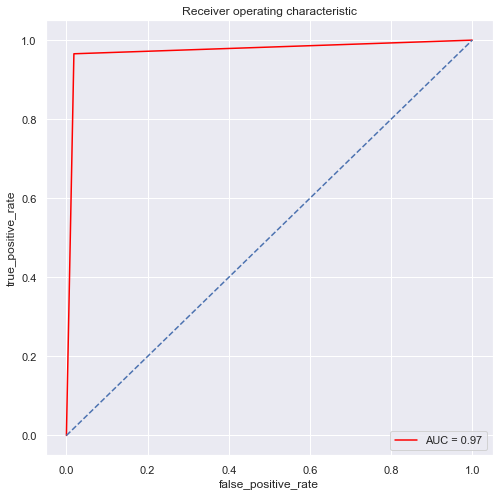

In [140]:
# Regardons ce que cela donne graphiquement. 

plt.figure(figsize = (8,8))
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate, true_positive_rate, color ='red', label = 'AUC = %0.2f' % roc_auc_svm)
plt.plot([0,1],[0,1], linestyle ='--')
plt.legend(loc = 'lower right')
plt.axis('tight')
plt.ylabel('true_positive_rate')
plt.xlabel('false_positive_rate')
plt.show()

>La méthode SVM semble un peu moins performante que la régression logistique. Il y a plus d'erreurs de prédiction et les scores de performance sont un peu moins bons. 

### 3.4. Méthode K-NN<a class="anchor" id="Methode_kNN"></a>

Le k-NN est le diminutif de k Nearest Neighbors. C’est un algorithme qui peut servir autant pour la classification que pour la régression. Il est surnommé « nearest neighbors » (plus proches voisins, en français) car le principe de ce modèle consiste en effet à choisir les k données les plus proches du point étudié afin d’en prédire sa valeur.

Le k-NN est un algorithme qui n’utilise pas de modèle statistique. Il est "non paramétrique" et il se base uniquement sur les données d’entraînement.

Le nombre k (nombre de voisins) est l'hyperparamètre que l’on va chercher à optimiser pour minimiser l’erreur sur les données test.

#### 3.4.a Grid Search<a class="anchor" id="Methode_kNN_gridsearch"></a>

In [141]:
# On commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Nous choisissons un score à optimiser, ici l'auc roc
score = 'roc_auc'

# Créons un classifieur kNN avec recherche d'hyperparamètre par validation croisée
knn = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

In [142]:
# Optimisons ce classifieur sur le jeu d'entraînement
knn.fit(X_train, y_train)

# Affichons le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(knn.best_params_)
print("Meilleur score (accuracy):")
print(round(knn.best_score_,3))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}
Meilleur score (accuracy):
0.994


In [143]:
# Affichons les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        knn.cv_results_['mean_test_score'], # score moyen
        knn.cv_results_['std_test_score'],  # écart-type du score
        knn.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
roc_auc = 0.985 (+/-0.015) for {'n_neighbors': 3}
roc_auc = 0.986 (+/-0.015) for {'n_neighbors': 5}
roc_auc = 0.990 (+/-0.015) for {'n_neighbors': 7}
roc_auc = 0.992 (+/-0.017) for {'n_neighbors': 9}
roc_auc = 0.992 (+/-0.017) for {'n_neighbors': 11}
roc_auc = 0.992 (+/-0.017) for {'n_neighbors': 13}
roc_auc = 0.994 (+/-0.010) for {'n_neighbors': 15}


In [144]:
# Testons à présent l'erreur de notre classifier

error = 1 - knn.score(X_test, y_test)
print('Erreur: %f' % error)

Erreur: 0.004644


>Comme on peut le voir, le k-NN le plus performant est celui pour lequel k = 5. On connaît donc notre classifieur final optimal : 5-nn. Ce qui veut dire que c'est celui qui classifie le mieux les données, et qui donc dans ce cas précis reconnaît au mieux l'authenticité des billets.

#### 3.4.b Instanciation - Entraînement - Prédictions<a class="anchor" id="kNN_instanciation_entrainement_predictions"></a>

In [145]:
# On récupère le classifieur le plus performant et on l'entraîne.
knn = neighbors.KNeighborsClassifier(15)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [146]:
# Ensuite nous pouvons prédire y_pred avec la méthode predict appliquée à X_test. 

y_pred = knn.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], d

#### 3.4.c Evaluation<a class="anchor" id="kNN_evaluation"></a>

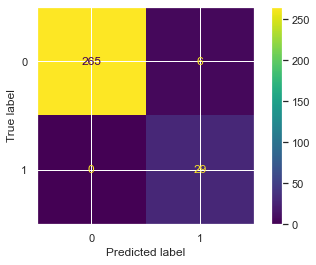

In [147]:
# Créons maintenant la matrice de confusion

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [148]:
# Et sous forme de dataframe

confusion(y_test,y_pred)

,pred_0,pred_1
test_0,265,6
test_1,0,29


In [149]:
# Calculons nos scores de performance : Accuracy, Precision et Rappel

KF = KFold(n_splits = 5)

accuracy_KNN_list = []
precision_KNN_list = []
recall_KNN_list = []

for i, (train_index, test_index) in enumerate(KF.split(X)) :
    print('{}\n'.format(i))
    # print(train_index, test_index)
    X_train, y_train = X.iloc[train_index],y.iloc[train_index]
    print(X_train.shape, y_train.shape)
    X_test, y_test = X.iloc[test_index],y.iloc[test_index]
    print(X_test.shape, y_test.shape)
    
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    print("Accuracy :",accuracy_score(y_test, y_pred).round(4))
    accuracy_KNN_list.append(accuracy_score(y_test, y_pred).round(4))
    
    print("Precision :",precision_score(y_test, y_pred).round(4))
    precision_KNN_list.append(precision_score(y_test, y_pred).round(4))
    
    print("Recall :",recall_score(y_test, y_pred).round(4))
    recall_KNN_list.append(recall_score(y_test, y_pred).round(4)) 

0

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 1.0
Precision : 1.0
Recall : 1.0
1

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9967
Precision : 1.0
Recall : 0.9967
2

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9933
Precision : 1.0
Recall : 0.9933
3

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.97
Precision : 0.8875
Recall : 1.0
4

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.98
Precision : 0.8286
Recall : 1.0


In [150]:
knn_accuracy = statistics.mean(accuracy_KNN_list).round(4)
knn_accuracy

0.988

In [151]:
knn_precision = statistics.mean(precision_KNN_list).round(4)
knn_precision

0.9432

In [152]:
knn_recall = statistics.mean(recall_KNN_list).round(4)
knn_recall

0.998

>Nous obtenons encore d'excellents scores de prédictions et seulement 4 erreurs de prédictions. 

### 3.5. Randomforest<a class="anchor" id="Random_forest"></a>

La méthode Random Forest est une technique de machine learning qui combine plusieurs arbres de décision pour améliorer la précision des prévisions. Plus précisément, la méthode Random Forest crée un grand nombre d'arbres de décision, chacun étant construit sur un échantillon aléatoire de données d'entraînement et un sous-ensemble aléatoire de variables explicatives. Chaque arbre donne une prédiction et le résultat final est obtenu en combinant les prédictions de tous les arbres.

#### 3.5.a Grid Search<a class="anchor" id="Random_forest_gridsearch"></a>

In [153]:
# Grid search sur une cross validation : 
# Dans le cas du random forest, il s'agit typiquement du nombre d'arbres et du nombre de variables.

rf = RandomForestClassifier()

# Nous choisissons un score à optimiser, ici l'auc_roc.

score = 'roc_auc'

# Nous fixons les valeurs des hyperparamètres à tester

parameters = {'n_estimators' : [100,200,300,400,500,600,700,800,900,1000],
              'max_depth' : [4,5,6,7,8]}

# Créons un classifieur rf avec recherche d'hyperparamètres par validation croisée

rf_cv = GridSearchCV(rf, parameters, scoring = score, cv = 5, verbose=0)

# # Optimisons ce classifieur sur le jeu d'entraînement

rf_cv.fit(X_train, y_train)

print("Meilleurs paramètres :",rf_cv.best_params_)
print("Meilleur score (roc_auc):",round(rf_cv.best_score_,4))

Meilleurs paramètres : {'max_depth': 7, 'n_estimators': 800}
Meilleur score (roc_auc): 0.9995


In [154]:
# Affichons les performances correspondantes

print("Résultats de la validation croisée :")
for mean, std, params in zip(
        rf_cv.cv_results_['mean_test_score'], # score moyen
        rf_cv.cv_results_['std_test_score'],  # écart-type du score
        rf_cv.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 100}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 200}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 300}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 400}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 500}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 600}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 700}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 800}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 900}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 4, 'n_estimators': 1000}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 5, 'n_estimators': 100}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 5, 'n_estimators': 200}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 5, 'n_estimators': 300}
roc_auc = 0.999 (+/-0.001) for {'max_depth': 5, 'n_estimators': 4

#### 3.5.b Instanciation - Entraînement - Prédictions<a class="anchor" id="Random_forest_instanciation_entrainement_predictions"></a>

In [155]:
# Instancions notre modèle Random Forest, avec les meilleurs paramètres.
# Nous l’adaptons ensuite à nos données d’entraînement. Nous passons à la fois les fonctionnalités et la variable cible, 
# afin que le modèle puisse apprendre.

rf = RandomForestClassifier(random_state = 42, max_depth = 6, n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

In [156]:
# À ce stade, nous avons un modèle de Random Forest entraîné et nous pouvons faire nos prédictions.

y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], d

#### 3.5.c Evaluation<a class="anchor" id="Random_forest_evaluation"></a>

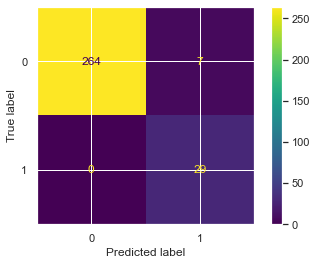

In [157]:
# Evaluons la performance de notre modèle en regardant ce que donne la matrice de confusion

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [158]:
confusion(y_test,y_pred)

,pred_0,pred_1
test_0,264,7
test_1,0,29


In [159]:
# Calculons nos scores de performance : Accuracy, Precision et Rappel

KF = KFold(n_splits = 5)

accuracy_RF_list = []
precision_RF_list = []
recall_RF_list = []

for i, (train_index, test_index) in enumerate(KF.split(X)) :
    print('{}\n'.format(i))
    # print(train_index, test_index)
    X_train, y_train = X.iloc[train_index],y.iloc[train_index]
    print(X_train.shape, y_train.shape)
    X_test, y_test = X.iloc[test_index],y.iloc[test_index]
    print(X_test.shape, y_test.shape)
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print("Accuracy :",accuracy_score(y_test, y_pred).round(4))
    accuracy_RF_list.append(accuracy_score(y_test, y_pred).round(4))
    
    print("Precision :",precision_score(y_test, y_pred).round(4))
    precision_RF_list.append(precision_score(y_test, y_pred).round(4))
    
    print("Recall :",recall_score(y_test, y_pred).round(4))
    recall_RF_list.append(recall_score(y_test, y_pred).round(4)) 

0

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 1.0
Precision : 1.0
Recall : 1.0
1

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9967
Precision : 1.0
Recall : 0.9967
2

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9967
Precision : 1.0
Recall : 0.9967
3

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9767
Precision : 0.9103
Recall : 1.0
4

(1200, 6) (1200,)
(300, 6) (300,)
Accuracy : 0.9767
Precision : 0.8056
Recall : 1.0


In [160]:
rf_accuracy = statistics.mean(accuracy_RF_list).round(4)
rf_accuracy

0.9894

In [161]:
rf_precision = round(statistics.mean(precision_RF_list),4)
rf_precision

0.9432

In [162]:
rf_recall = round(statistics.mean(recall_RF_list),4)
rf_recall

0.9987

>Les  scores obtenus sont à nouveau très bons.

Le code ci-dessous trace l’importance de chaque variable, en utilisant le score interne du modèle pour trouver la meilleure façon de diviser les données dans chaque arbre de décision.

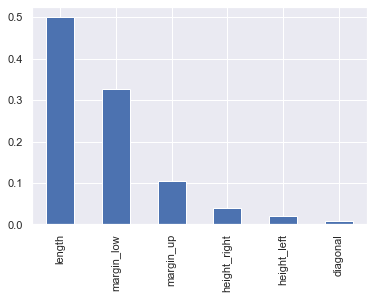

In [163]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()
plt.show()

### 3.6. Méthode des K-Means<a class="anchor" id="Methode_kmeans"></a>

La méthode KMeans est une méthode de clustering qui consiste à choisir un nombre de clusters et à placer de façon aléatoire autant de centroïdes que nous avons de clusters. Puis chaque point du dataset est affecté au centroïde le plus proche et ensuite le centroïde se déplace au centre du cluster ainsi formé. Cette opération se répète jusqu’à ce que les centroïdes convergent vers une position d’équilibre. 

#### 3.6.a. Préparation et standardisation des données<a class="anchor" id="preparation_et_standardisation_des_donnees"></a>

In [164]:
# Je reprends mon dataframe billets

billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [165]:
# Je sépare mes données

X = billets.drop(columns = 'is_genuine')
y = billets.is_genuine

In [166]:
# Commençons par scaler les données. On instancie notre scaler :

scaler_kmeans = StandardScaler()

In [167]:
# On fit et on transforme nos données X (centrage réduction)

X_scaled = scaler_kmeans.fit_transform(X)
X_scaled[:5]

array([[-0.48653957,  2.77412327,  3.16324041,  0.05546738, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08215668, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12655247, -0.91256208,
         0.55190114],
       [-1.96149786, -0.39929381,  0.06049835, -1.30968149, -0.61049399,
         0.95307539],
       [-0.74875438,  0.83666863, -1.41407214, -0.67261202,  1.41767746,
        -0.15875038]])

In [168]:
# Séparons nos données en un groupe d'entrainement et un groupe de test. 
 
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [169]:
# On espère avoir une moyenne à 0 et un écart type à 1 :

idx = ["mean", "std"]

pd.DataFrame(X_scaled_train).describe().round(1).loc[idx, :]

,0,1,2,3,4,5
mean,0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [170]:
# J'enregistre mes données d'entrainement scalées dans un dataframe billets_X_scaled

billets_X_scaled_train = pd.DataFrame(X_scaled_train, columns = ['diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'])
billets_X_scaled_train.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.978192,-1.267808,-1.475513,-1.855741,-0.696799,0.242424
1,-1.305961,-1.969300,0.521302,-0.111384,-0.783104,1.044772
2,-1.830390,1.170713,0.828504,0.441800,0.079947,-0.330682
3,-0.191548,0.736455,2.210914,-0.035543,-0.351578,-2.084387
4,1.447295,0.469220,0.521302,-0.035543,-0.567341,0.551901


#### 3.6.b. Méthode du coude et coefficient de silhouette<a class="anchor" id="Methode_du_coude_et_silhouette_score"></a>

Nous souhaitons obtenir deux clusters. Un cluster vrais billets et un cluster faux billets. 
Nous allons voir si nos données se séparent idéalement en deux clusters

In [171]:
inertia = []

In [172]:
k_list = range(1, 8)
list(k_list)

[1, 2, 3, 4, 5, 6, 7]

In [173]:
for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_scaled_train) 
  inertia.append(kmeans.inertia_)

In [174]:
inertia

[7227.403789772186,
 4698.159632703778,
 4103.3180659425525,
 3758.1384067306108,
 3512.9745079670083,
 3297.425995074025,
 3148.2660437065083]

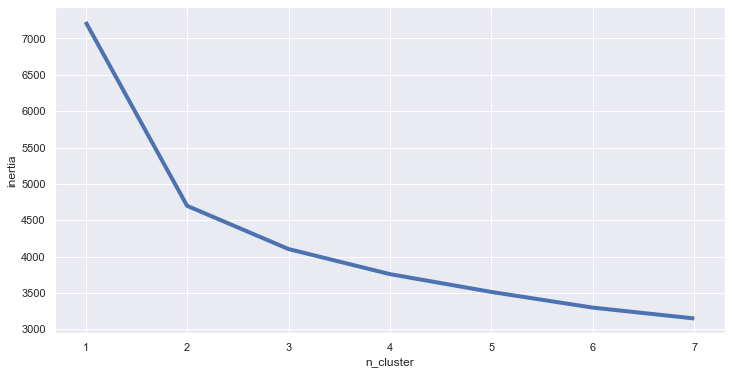

In [175]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")
plt.style.use("fivethirtyeight")
ax = plt.plot(k_list, inertia)

>La méthode du coude nous indique bien un partitionnement en deux clusters.
Ça tombe bien, c'est ce que nous voulons.

In [176]:
# Regardons par curiosité ce que cela donne avec le coefficient de silhouette

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_scaled_train, kmeans.labels_))

Silhouette Coefficient: 0.145


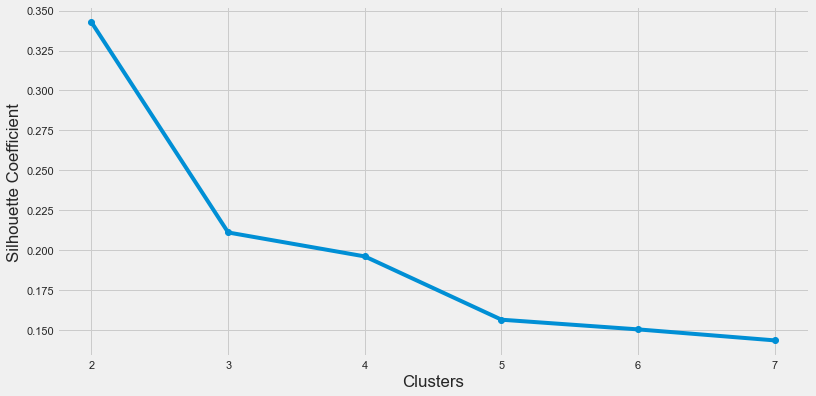

In [177]:
# Version graphique du silhouette score

X_norm = preprocessing.scale(X_scaled_train)

Silhouettes = []
for num_clusters in range (2, 8) :
    cls = cluster.KMeans(n_clusters = num_clusters,
                        n_init = 10, init = 'k-means++', random_state=0, max_iter = 300)
    cls.fit(X_norm)
    silh = metrics.silhouette_score(X_norm, cls.labels_)
    Silhouettes.append(silh)
    
fig, ax = plt.subplots(1,1,figsize=(12,6))    
    
plt.plot(range (2, 8), Silhouettes,marker = 'o')
plt.style.use("fivethirtyeight")
plt.ylabel('Silhouette Coefficient')
plt.xlabel('Clusters')
plt.show()

>De la même façon, nos données se séparent idéalement en 2 clusters

#### 3.6.c. Instanciation  - Entraînement - Prédictions<a class="anchor" id="kmeans_instanciation_entrainement_predictions"></a>

In [178]:
# On instancie donc notre Kmeans avec 2 clusters : 

modele_kmeans = KMeans(n_clusters=2, random_state =0)

# On l'entraine sur nos données d'entraînement: 

modele_kmeans.fit(X_scaled_train, y_train)

KMeans(n_clusters=2, random_state=0)

In [179]:
# On prédit y_pred à partir de X_scaled_test

y_pred = modele_kmeans.predict(X_scaled_test)
y_pred

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [180]:
# On peut stocker nos clusters dans une variable labels : 

labels = modele_kmeans.labels_
labels

array([1, 1, 0, ..., 1, 0, 0])

In [181]:
# Effectifs par cluster

np.unique(modele_kmeans.labels_,return_counts = True)

(array([0, 1]), array([386, 814], dtype=int64))

In [182]:
# J'ajoute la variable 'cluster' à mon dataframe

billets_X_scaled_train['cluster'] = labels
billets_X_scaled_train

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,-0.978192,-1.267808,-1.475513,-1.855741,-0.696799,0.242424,1
1,-1.305961,-1.969300,0.521302,-0.111384,-0.783104,1.044772,1
2,-1.830390,1.170713,0.828504,0.441800,0.079947,-0.330682,0
3,-0.191548,0.736455,2.210914,-0.035543,-0.351578,-2.084387,0
4,1.447295,0.469220,0.521302,-0.035543,-0.567341,0.551901,1
...,...,...,...,...,...,...,...
1195,-0.125994,0.870073,1.074266,1.936339,-0.092663,-1.499819,0
1196,0.463989,0.636242,0.214099,1.177923,0.382015,-0.846478,0
1197,2.004501,-0.833551,-0.830388,-0.323741,-0.481036,0.368507,1
1198,0.758981,2.005822,1.596509,1.193091,0.942999,-1.958303,0


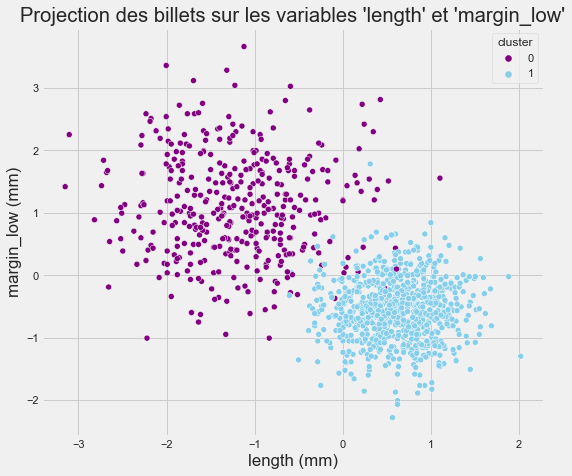

In [183]:
# On peut afficher nos points coloriés en fonction du cluster auquel ils appartiennent

# Je peux projeter mes billets sur les variables 'diagonal' et 'margin_low'

fig, ax = plt.subplots(1,1, figsize=(8,7))
plt.title("Projection des billets sur les variables 'length' et 'margin_low'")
sns.scatterplot(data = billets_X_scaled_train, x = 'length', y = 'margin_low', hue = "cluster",  palette = {0:'purple',1:'skyblue'})
ax.set_xlabel("length (mm)")
ax.set_ylabel("margin_low (mm)")
plt.show()

#### 3.6.d. Centroïdes<a class="anchor" id="Centroides"></a>

In [184]:
# On peut stocker nos centroïdes dans une variable 'centroids' : 

centroids = modele_kmeans.cluster_centers_
centroids

array([[-0.19596345,  0.57852019,  0.72647448,  1.10376792,  0.84752674,
        -1.21290921],
       [ 0.11459753, -0.27236534, -0.35075253, -0.55830275, -0.42595573,
         0.60217114]])

In [185]:
# Et afficher ces données dans un dataframe

centroids = pd.DataFrame(centroids, index=["cluster_0", "cluster_1"], columns = ['diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'])
centroids

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster_0,-0.195963,0.578520,0.726474,1.103768,0.847527,-1.212909
cluster_1,0.114598,-0.272365,-0.350753,-0.558303,-0.425956,0.602171


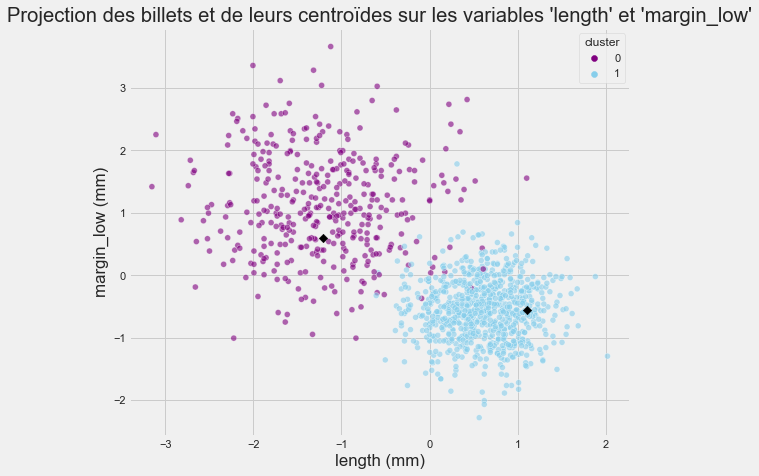

In [186]:
# On affiche le graphique pour les variables length et margin_low

# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))
plt.title("Projection des billets et de leurs centroïdes sur les variables 'length' et 'margin_low'")

# On affiche nos billets, avec une transparence de 40% (alpha=0.6) : 
sns.scatterplot(data = billets_X_scaled_train, x = 'length', y = 'margin_low', hue = 'cluster', palette = {0:'purple',1:'skyblue'}, alpha =0.6)

# On affiche nos centroides, avec une couleur noire (c="black") et une forme de losange (marker="D") : 
ax.scatter(centroids.iloc[0, [3,5]], centroids.iloc[1,[3,5]],  marker="D", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("length (mm)")
ax.set_ylabel("margin_low (mm)")
plt.show()

Rappelons que nos centroïdes ne se situent pas au centre du nuage de points sur le graphique car ne sont représentées que 2 variables sur les 6. Pour que nos centroïdes soient situés au milieu du nuage de point, il faudrait pouvoir visualiser les 6 variables simultanément, donc avoir un graphique à 6 dimensions !

J'ai testé une ACP sur notre jeu de données. L'éboulis des valeurs propres m'indiquait de travailler sur les 5 premières composantes principales. 

La réduction de dimension dans notre cas ne présente pas grand intérêt car nous devons garder 5 composantes au lieu des 6 variables originales pour conserver suffisament de variance (95% minimum, c'est ce que j'obtenais avec 5 composantes). Aussi, la création de nouvelles variables synthétiques generera davantage d'erreurs puisque nous n'aurons pas 100% des caractéristiques des variables originales. 

>Avec notre K-Means, pour identifier un billet qui appartiendra au cluster 0 ou 1, il conviendra de calculer sa distance par rapport aux coordonnées des deux centroïdes. Le billet appartiendra au cluster dont les valeurs des variables scalées seront les plus proches de son centroïde.

#### 3.6.e. Evaluation<a class="anchor" id="KMeans_evaluation"></a>

In [187]:
# Voyons la matrice de confusion

confusion(y_pred,y_test)

,pred_0,pred_1
test_0,106,4
test_1,5,185


In [188]:
# Calculons nos scores de performance :
    
kmeans_accuracy = accuracy_score(y_test, y_pred).round(4)
print("Accuracy :",kmeans_accuracy)

kmeans_precision = precision_score(y_test, y_pred).round(4)
print("Precision :",kmeans_precision)

kmeans_recall = recall_score(y_test, y_pred).round(4)
print("Recall :",kmeans_recall)

Accuracy : 0.97
Precision : 0.9737
Recall : 0.9788


>Il semble y avoir un peu plus d'erreur de prédictions avec le modèle KMeans toutefois il donne de bons scores. 

#### 3.6.f. Prédictions sur de nouveaux billets<a class="anchor" id="KMeans_predictions_nouveaux_billets"></a>

Nous allons maintenant tester la méthode des KMeans pour déterminer l'authenticité de nouveaux billets

In [189]:
# Reprenons nos centroïdes

centroids

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster_0,-0.195963,0.578520,0.726474,1.103768,0.847527,-1.212909
cluster_1,0.114598,-0.272365,-0.350753,-0.558303,-0.425956,0.602171


In [190]:
# Importons nos nouvelles données

billets_production = pd.read_csv('billets_production.csv')
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [191]:
# Je change l'index du fichier par l'id du billet pour garder uniquement mes 6 variables decriptives 

billets_production = billets_production.set_index('id')
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42
A_2,171.87,104.17,104.13,6.00,3.31,112.09
A_3,172.00,104.58,104.29,4.99,3.39,111.57
A_4,172.49,104.55,104.34,4.44,3.03,113.20
A_5,171.65,103.63,103.56,3.77,3.16,113.33


In [192]:
# Je définis X, la matrice de mes données

X = billets_production.values
X

array([[171.76, 104.01, 103.54,   5.21,   3.3 , 111.42],
       [171.87, 104.17, 104.13,   6.  ,   3.31, 112.09],
       [172.  , 104.58, 104.29,   4.99,   3.39, 111.57],
       [172.49, 104.55, 104.34,   4.44,   3.03, 113.2 ],
       [171.65, 103.63, 103.56,   3.77,   3.16, 113.33]])

In [193]:
# Je standardise mes nouvelles données avec le scaler déjà entraîné. 

X_scaled = scaler_kmeans.transform(X)
X_scaled

array([[-0.65042383, -0.06524991, -1.16831039,  1.10208152,  0.64093095,
        -1.44250797],
       [-0.28987847,  0.46922034,  0.6441825 ,  2.30037887,  0.68408353,
        -0.67454584],
       [ 0.13622059,  1.83880034,  1.135706  ,  0.76837846,  1.02930421,
        -1.27057615],
       [ 1.74228629,  1.73858717,  1.28930709, -0.06587918, -0.52418882,
         0.59774963],
       [-1.01096919, -1.33461674, -1.10686995, -1.08215668,  0.03679477,
         0.74675721]])

In [194]:
# Je mets en forme mes données scalées dans un dataframe

df_X_scaled = pd.DataFrame(X_scaled, index = ['A_1','A_2','A_3','A_4','A_5'], columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length'])
df_X_scaled.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
A_1,-0.650424,-0.065250,-1.168310,1.102082,0.640931,-1.442508
A_2,-0.289878,0.469220,0.644183,2.300379,0.684084,-0.674546
A_3,0.136221,1.838800,1.135706,0.768378,1.029304,-1.270576
A_4,1.742286,1.738587,1.289307,-0.065879,-0.524189,0.597750
A_5,-1.010969,-1.334617,-1.106870,-1.082157,0.036795,0.746757


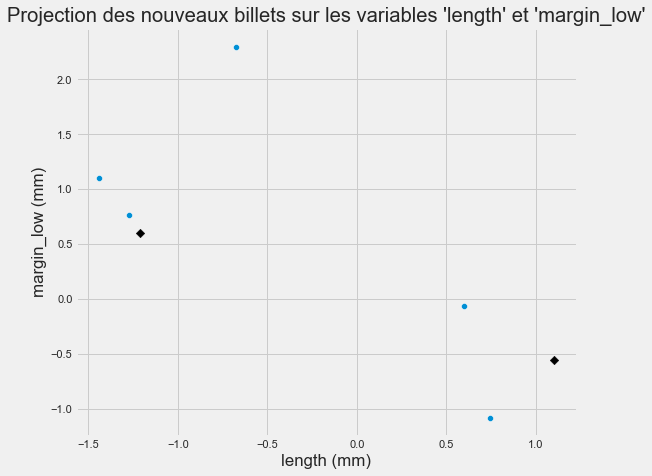

In [195]:
# On affiche le graphique pour les variables diagonal et margin_low

# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))
plt.title("Projection des nouveaux billets sur les variables 'length' et 'margin_low'")

# On affiche nos billets : 
sns.scatterplot(data = df_X_scaled, x = 'length', y = 'margin_low')

# On affiche nos centroides, avec une couleur noire (c="black") et une forme de losange (marker="D") : 
ax.scatter(centroids.iloc[0, [3,5]], centroids.iloc[1,[3,5]],  marker="D", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("length (mm)")
ax.set_ylabel("margin_low (mm)")
plt.show()

>En projetant sur deux variables, on visualise trois faux billets et 2 vrais billets
Mais pour être certain des clusters, il faut prendre en compte toutes les variables. 

In [196]:
# Pour plus de précision et surtout pour prendre en compte l'ensemble des variables, nous allons calculer 
# la distance euclidienne entre les deux centroïdes et chacun des billets pour savoir s'ils appartiennent
# au cluster "True" ou au cluster "False"
  
# Coordonnées du 1er centroïde (Centroïde True)
C_True = centroids.iloc[1,:]

# Coordonnées du 2ème centroïde (Centroïde False)
C_False = centroids.iloc[0,:]

# Coordonnées de chacun des billets
A_1 = df_X_scaled.iloc[0,:]
A_2 = df_X_scaled.iloc[1,:]
A_3 = df_X_scaled.iloc[2,:]
A_4 = df_X_scaled.iloc[3,:]
A_5 = df_X_scaled.iloc[4,:]

In [197]:
data = [[round(math.dist(C_False, A_1),4), round(math.dist(C_True, A_1),4)],[round(math.dist(C_False, A_2),4),round(math.dist(C_True, A_2),4)],
       [round(math.dist(C_False, A_3),4), round(math.dist(C_True, A_3),4)],[round(math.dist(C_False, A_4),4), round(math.dist(C_True, A_4),4)],
       [round(math.dist(C_False, A_5),4), round(math.dist(C_True, A_5),4)]]
            
result_kmeans = pd.DataFrame(index = ['A_1','A_2','A_3','A_4','A_5'], columns = ['distance_centroid_False', 'distance_centroid_True'], data = data)
result_kmeans

,distance_centroid_False,distance_centroid_True
A_1,2.0752,3.0614
A_2,1.3327,3.5690
A_3,1.4195,3.7486
A_4,3.4565,3.1041
A_5,4.1184,1.8645


In [198]:
# Comparons maintenant les distances des billets aux centroïdes False et True
# Si la distance entre A_1 le le centroïde False est plus petite que la distance entre A_1 et le centroïde True alors le 
# billet sera False. A l'inverse, il sera True.

f = result_kmeans['distance_centroid_False']
t = result_kmeans['distance_centroid_True']

result_kmeans['prediction'] = np.where(f<t, 'False', 'True')
result_kmeans

,distance_centroid_False,distance_centroid_True,prediction
A_1,2.0752,3.0614,False
A_2,1.3327,3.5690,False
A_3,1.4195,3.7486,False
A_4,3.4565,3.1041,True
A_5,4.1184,1.8645,True


>Avec la méthode des kmeans les billets A_1, A_2 et A_3 sont faux et les billets A_4 et A_5 sont vrais.

## 4. Comparaison des performances des modèles<a class="anchor" id="Comparaison_performances"></a>

Nous allons maintenant comparer les scores de performance des modèles testés.

In [199]:
cols = ['Dummy_classifier','Regression_Logistique','SVM','kNN','Randomforest','kmeans']
index = ['Accuracy','Precision','Rappel']

performance_modele = pd.DataFrame(index = index, columns = cols)

performance_modele['Dummy_classifier'] = [dc_accuracy,dc_precision,dc_recall]
performance_modele['Regression_Logistique'] = [rl_accuracy,rl_precision,rl_recall]
performance_modele['SVM'] = [svm_accuracy,svm_precision,svm_recall]
performance_modele['kNN'] = [knn_accuracy,knn_precision,knn_recall]
performance_modele['Randomforest'] = [rf_accuracy,rf_precision,rf_recall]
performance_modele['kmeans'] = [kmeans_accuracy,kmeans_precision,kmeans_recall]

performance_modele

,Dummy_classifier,Regression_Logistique,SVM,kNN,Randomforest,kmeans
Accuracy,0.63,0.9893,0.9833,0.9880,0.9894,0.9700
Precision,0.63,0.9664,0.9368,0.9432,0.9432,0.9737
Rappel,1.00,0.9898,0.9898,0.9980,0.9987,0.9788


>De cette comparaison, nous pouvons dire que les cinq modèles sont excellents, et notamment notre modèle de régression logistique qui donne les meilleurs scores de performance. 

>Nous allons donc utiliser ce modèle de régression logistique  pour notre application finale, c’est-à-dire pour prédire l’authenticité ou non de nouveaux billets

## 5. Application finale<a class="anchor" id="Application_finale"></a>

Pour l'application finale, j'ai choisi la régression logistique. 
Il s'agit maintenant de tester ce modèle sur de nouvelles données. 

In [240]:
# J'importe mes nouvelles données

billets_production = pd.read_csv('billets_production.csv',sep=",", decimal='.')
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [241]:
# Je change l'index par l'id du billet pour garder uniquement mes 6 variables decriptives 

billets_production = billets_production.set_index('id')
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42
A_2,171.87,104.17,104.13,6.00,3.31,112.09
A_3,172.00,104.58,104.29,4.99,3.39,111.57
A_4,172.49,104.55,104.34,4.44,3.03,113.20
A_5,171.65,103.63,103.56,3.77,3.16,113.33


In [242]:
# J'enregistre les données du fichier dans une variable X

X = billets_production.values

In [243]:
# Je scale les nouvelles données avec le scaler déjà entrainé

X_scaled = scaler.transform(X)
X_scaled

array([[-0.65042383, -0.06524991, -1.16831039,  1.10208152,  0.64093095,
        -1.44250797],
       [-0.28987847,  0.46922034,  0.6441825 ,  2.30037887,  0.68408353,
        -0.67454584],
       [ 0.13622059,  1.83880034,  1.135706  ,  0.76837846,  1.02930421,
        -1.27057615],
       [ 1.74228629,  1.73858717,  1.28930709, -0.06587918, -0.52418882,
         0.59774963],
       [-1.01096919, -1.33461674, -1.10686995, -1.08215668,  0.03679477,
         0.74675721]])

In [244]:
# Je calcule le résultat de ma prédiction
# (j'utilise bien l'estimateur de ma régression logistique)

y_pred = estimateur.predict(X_scaled)
y_pred

array([0, 0, 0, 0, 1], dtype=int64)

In [245]:
# Je calcule les probabilités que mon billet soit authentique ou faux

y_prob = estimateur.predict_proba(X_scaled).round(2)
y_prob

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.53, 0.47],
       [0.  , 1.  ]])

In [246]:
# Je ne conserve que la probabilité que mon billet soit authentique

proba_billet_authentique = y_prob[:,1]
proba_billet_authentique

array([0.  , 0.  , 0.  , 0.47, 1.  ])

In [247]:
# Je remets en forme mon dataframe billets_production

billets_production = pd.DataFrame(X_scaled, index = ['A_1','A_2','A_3','A_4','A_5'], columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length'])
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length
A_1,-0.650424,-0.065250,-1.168310,1.102082,0.640931,-1.442508
A_2,-0.289878,0.469220,0.644183,2.300379,0.684084,-0.674546
A_3,0.136221,1.838800,1.135706,0.768378,1.029304,-1.270576
A_4,1.742286,1.738587,1.289307,-0.065879,-0.524189,0.597750
A_5,-1.010969,-1.334617,-1.106870,-1.082157,0.036795,0.746757


In [248]:
# Je crée des nouvelles variables pour afficher mes résultats dans mon dataframe

billets_production['predictions'] = y_pred 
billets_production['predictions'] = billets_production['predictions'].replace([1,0],[True,False])
billets_production['proba_billet_authentique_(%)'] = (proba_billet_authentique * 100).round()
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length,predictions,proba_billet_authentique_(%)
A_1,-0.650424,-0.065250,-1.168310,1.102082,0.640931,-1.442508,False,0.0
A_2,-0.289878,0.469220,0.644183,2.300379,0.684084,-0.674546,False,0.0
A_3,0.136221,1.838800,1.135706,0.768378,1.029304,-1.270576,False,0.0
A_4,1.742286,1.738587,1.289307,-0.065879,-0.524189,0.597750,False,47.0
A_5,-1.010969,-1.334617,-1.106870,-1.082157,0.036795,0.746757,True,100.0


In [249]:
print("Résultats")
print("------------------------------------------------------------------------")
print("Le 1er billet est", billets_production.iloc[0,6], "avec", billets_production.iloc[0,7],"% de probabilité qu'il soit authentique")
print('Le 2ème billet est', billets_production.iloc[1,6], "avec", billets_production.iloc[1,7],"% de probabilité qu'il soit authentique")
print('Le 3ème billet est', billets_production.iloc[2,6], "avec", billets_production.iloc[2,7],"% de probabilité qu'il soit authentique")
print('Le 4ème billet est', billets_production.iloc[3,6], "avec", billets_production.iloc[3,7],"% de probabilité qu'il soit authentique")
print('Le 5ème billet est', billets_production.iloc[4,6], "avec", billets_production.iloc[4,7],"% de probabilité qu'il soit authentique")

Résultats
------------------------------------------------------------------------
Le 1er billet est False avec 0.0 % de probabilité qu'il soit authentique
Le 2ème billet est False avec 0.0 % de probabilité qu'il soit authentique
Le 3ème billet est False avec 0.0 % de probabilité qu'il soit authentique
Le 4ème billet est False avec 47.0 % de probabilité qu'il soit authentique
Le 5ème billet est True avec 100.0 % de probabilité qu'il soit authentique


>Nous pouvons constater que les deux méthodes (KMeans et régression logistique) ne donnent pas le même résultat. Il en ressort une différence de prédiction pour le billet A_4.
Toutefois, si nous regardons le résultat avec la méthode KMeans, nous pouvons voir que la distance du billet A_4 avec les deux centroïdes est très proche. 
>Avec la régression logistique, la probabilité qu'il soit vrai comme avec la méthode KMeans est de 47%. Notre résultat n'est donc pas incohérent. 
>En changeant certains paramètres de la régression logistique, nous pouvons facilement le faire basculer du côté des vrais billets. Je ne l'ai pas fait car les scores de performance obtenus étaient moins bons. 